In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5450299%2F9047145%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240731%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240731T092608Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D645ca6a41ff8e665e32ac12491830b8d4452f2ced0a13777b974e236f66811a38dde3d4772396937fae1a915aef1200a7557a8936b778bd731f8bc2df61a6152dafe781be8bd600538d38d5d68a0ef3c0cb740acd9bf4e31c35734f3f7e8535cc833efbcdaf712120bd646dc29684e67ce39e67cb3c57158d0144fb13d9fa6136dc5df6ca887c33c677485d07ebff5af79f4fd7002d335608dfeefb73957940eba3a9de88c1d5a9f240353a70e57e79a2ef3fb39d4f094d91f7bfbe010dd9e590dbda2774a3377539d332b04ee5e48fc340e8c08c34ab1ae6a7435e054c33b99f62d2a841daeeacf24b6210e622923ab7c71ddb3aecc311db37cfc8fb56c8777'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Important libraries
1. **os**: Provides a way to interact with the operating system for file and directory manipulation.
2. **numpy**:  crucial for efficient numerical computing in Python, providing support for large, multi-dimensional arrays and matrices along with a collection of mathematical functions to operate on these arrays.
3. **pandas**: Offers powerful data structures and data analysis tools for handling and analyzing structured data.
4. **matplotlib**: Enables the creation of static, animated, and interactive visualizations in Python.
5. **seaborn**: Simplifies the creation of informative and attractive statistical graphics built on top of matplotlib.
6. **scikit-learn**: Provides a comprehensive suite of tools for machine learning and data mining, including classification, regression, clustering, and dimensionality reduction.

In [ ]:
# Importing the required libraries and packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

# Data Collection

The project will use the **UDISE+ (2021-2022)** data set, developed at the *Department of School Education, Ministry of Education, Government of India*, and maintained by the *National Informatics Centre, Government of India*. This data set includes comprehensive information on school infrastructure, digital facilities, enrollment, and other relevant metrics across India.

The data tables relevant to the project topic are shortlisted and combined into an excel file of several sheets, uploaded on to Kaggle, named **Infrastructure_Technology_Education_India.xlsx** under the dataset **eduinfratechdataindia**.

This collected and shortlisted dataset contains the following data tables:
* school_no_tbl : quantitative data for schools
* enroll_tbl : student enrollment data
* prom_tbl : quantitative data for promotion
* rep_tbl : quantitative data for repetition
* drop_tbl : quantitative data for dropout
* trans_tbl : quantitative data for transition
* projector_tbl : quantitative data for projector availablity
* smart_class_tbl : quantitative data for smart class availablity
* dig_lib_tbl : quantitative data for digital library availablity
* infratech1_tbl : quantitative data for availablity a set of infratech facilities
* infratech2_tbl : quantitative data for availablity a set of infratech facilities

The following code shows how the original dataset is taken as input and prepared for further cleaning and transformation.

In [ ]:
# Checking for the input dataset in the input directory
print(os.listdir('../input'))

['Infrastructure_Technology_Education_India.xlsx']


In [ ]:
# Accessing the input dataset and checking for the input data tables included
raw_set_path='../input/Infrastructure_Technology_Education_India.xlsx'
raw_set=pd.read_excel(raw_set_path,sheet_name=None)
print(raw_set.keys())

dict_keys(['school_no_tbl', 'enroll_tbl', 'prom_tbl', 'drop_tbl', 'trans_tbl', 'rep_tbl', 'projector_tbl', 'smart_class_tbl', 'dig_lib_tbl', 'infratech1_tbl', 'infratech2_tbl'])


In [ ]:
# Extracting the different sheet (data tables) into different dataframes for data cleaning and transformation
school_no_tbl=pd.read_excel(raw_set_path,sheet_name='school_no_tbl')
print('school_no_tbl:',school_no_tbl.columns.tolist())
enroll_tbl=pd.read_excel(raw_set_path,sheet_name='enroll_tbl')
print('enroll_tbl:',enroll_tbl.columns.tolist())
prom_tbl=pd.read_excel(raw_set_path,sheet_name='prom_tbl')
print('prom_tbl:',prom_tbl.columns.tolist())
rep_tbl=pd.read_excel(raw_set_path,sheet_name='rep_tbl')
print('rep_tbl:',rep_tbl.columns.tolist())
drop_tbl=pd.read_excel(raw_set_path,sheet_name='drop_tbl')
print('drop_tbl:',drop_tbl.columns.tolist())
trans_tbl=pd.read_excel(raw_set_path,sheet_name='trans_tbl')
print('trans_tbl:',trans_tbl.columns.tolist())
projector_tbl=pd.read_excel(raw_set_path,sheet_name='projector_tbl')
print('projector_tbl:',projector_tbl.columns.tolist())
smart_class_tbl=pd.read_excel(raw_set_path,sheet_name='smart_class_tbl')
print('smart_class_tbl:',smart_class_tbl.columns.tolist())
dig_lib_tbl=pd.read_excel(raw_set_path,sheet_name='dig_lib_tbl')
print('dig_lib_tbl:',dig_lib_tbl.columns.tolist())
infratech1_tbl=pd.read_excel(raw_set_path,sheet_name='infratech1_tbl')
print('infratech1_tbl:',infratech1_tbl.columns.tolist())
infratech2_tbl=pd.read_excel(raw_set_path,sheet_name='infratech2_tbl')
print('infratech2_tbl:',infratech2_tbl.columns.tolist())

school_no_tbl: ['India/ State /UT', 'Total', 'Primary', 'Upper Primary', 'Secondary', 'Higher Secondary']
enroll_tbl: ['India/ State /UT', 'Total', 'Pre- Primary', 'Primary (1 to 5)', 'Upper Primary\n(6-8)', 'Elementary (1-8)', 'Secondary (9-10)', 'Higher Secondary\n(11-12)']
prom_tbl: ['India/ State /UT', 'P Boys', 'P Girls', 'P Total', 'UP Boys', 'UP Girls', 'UP Total', 'S Boys', 'S Girls', 'S Total']
rep_tbl: ['India/ State /UT', 'P Boys', 'P Girls', 'P Total', 'UP Boys', 'UP Girls', 'UP Total', 'S Boys', 'S Girls', 'S Total']
drop_tbl: ['India/ State /UT', 'P Boys', 'P Girls', 'P Total', 'UP Boys', 'UP Girls', 'UP Total', 'S Boys', 'S Girls', 'S Total']
trans_tbl: ['India/ State /UT', 'P Boys', 'P Girls', 'P Total', 'UP Boys', 'UP Girls', 'UP Total', 'S Boys', 'S Girls', 'S Total']
projector_tbl: ['India/ State /UT', 'TS All management', 'TS Government', 'TS Government Aided', 'TS Pvt. Unaided', 'TS Others', 'All management (N)', 'Government (N)', 'Government Aided (N)', 'Pvt. Unai

# Data Cleaning and Transformation
Since the data is collected from reliable government sources, there is no need to handle missing values, outliers, and inconsistencies in the data. This can be verified at last after obtaining the final dataset.

Apart from that, we do need to eliminate unnecessary data columns (that have no significance in our study), rename the columns as per requirement and convinience, standardize data formats, and integrate the different tables into a final dataset;

*Dataframe* : **'final_set'**
*Output File* : **'modified_file.xlsx'**

This final dataset is then checked for any missing values or data inconsistencies.

## Cleaning and Transformation

In [ ]:
#school_no_tbl
school_no_tbl=school_no_tbl.drop(school_no_tbl.columns[2:],axis=1)
print('school_no_tbl:',school_no_tbl.columns.tolist())
#enroll_tbl
enroll_tbl=enroll_tbl.drop(enroll_tbl.columns[2:],axis=1)
enroll_tbl.rename(columns={'Total':'Enrollment'},inplace=True)
print('enroll_tbl:',enroll_tbl.columns.tolist())
#prom_tbl
prom_tbl['Promotion Rate'] = prom_tbl[['P Total', 'UP Total', 'S Total']].mean(axis=1)
prom_tbl=prom_tbl[['India/ State /UT','Promotion Rate']]
print('prom_tbl:',prom_tbl.columns.tolist())
#drop_tbl
drop_tbl['Dropout Rate'] = drop_tbl[['P Total','UP Total','S Total']].mean(axis=1)
drop_tbl=drop_tbl[['India/ State /UT','Dropout Rate']]
print('drop_tbl:',drop_tbl.columns.tolist())
#trans_tbl
trans_tbl['Transition Rate'] = trans_tbl[['P Total','UP Total','S Total']].mean(axis=1)
trans_tbl=trans_tbl[['India/ State /UT','Transition Rate']]
print('trans_tbl:',trans_tbl.columns.tolist())
#rep_tbl
rep_tbl['Repetition Rate'] = rep_tbl[['P Total','UP Total','S Total']].mean(axis=1)
rep_tbl=rep_tbl[['India/ State /UT','Repetition Rate']]
print('rep_tbl:',rep_tbl.columns.tolist())
#projector_tbl
projector_tbl=projector_tbl[['India/ State /UT','All management (%)']]
projector_tbl.rename(columns={'All management (%)':'Projector'},inplace=True)
print('projector_tbl:',projector_tbl.columns.tolist())
#smart_class_tbl
smart_class_tbl=smart_class_tbl[['India/ State /UT','All management (%)']]
smart_class_tbl.rename(columns={'All management (%)':'Smart Class'},inplace=True)
print('smart_class_tbl:',smart_class_tbl.columns.tolist())
#dig_lib_tbl
dig_lib_tbl=dig_lib_tbl[['India/ State /UT','All management (%)']]
dig_lib_tbl.rename(columns={'All management (%)':'Digital Library'},inplace=True)
print('dig_lib_tbl:',dig_lib_tbl.columns.tolist())
#infratech1_tbl
infratech1_tbl=infratech1_tbl.drop(infratech1_tbl.columns[[4,6,8,10,12]],axis=1)
numeric_cols = infratech1_tbl.select_dtypes(include=['number']).columns
infratech1_tbl[numeric_cols] = infratech1_tbl[numeric_cols].astype(float)
for i in range(2,8):
    infratech1_tbl.iloc[:,i]=(infratech1_tbl.iloc[:,i]/infratech1_tbl.iloc[:,1])*100
infratech1_tbl=infratech1_tbl.drop(infratech1_tbl.columns[[1]],axis=1)
infratech1_tbl.rename(columns={'Library/ Book Bank/ Reading Corner':'Library',"Functional Girls' Toilet":"Girls' Toilet","Functional Boys' Toilet":"Boys' Toilet","Functional Electricity":"Electricity"},inplace=True)
print('infratech1_tbl:',infratech1_tbl.columns.tolist())
#infratech2_tbl
infratech2_tbl=infratech2_tbl.drop(infratech2_tbl.columns[[2,5,8,9]],axis=1)
numeric_cols = infratech2_tbl.select_dtypes(include=['number']).columns
infratech2_tbl[numeric_cols] = infratech2_tbl[numeric_cols].astype(float)
for i in range(2,9):
    infratech2_tbl.iloc[:,i]=(infratech2_tbl.iloc[:,i]/infratech2_tbl.iloc[:,1])*100
infratech2_tbl=infratech2_tbl.drop(infratech2_tbl.columns[[1]],axis=1)
infratech2_tbl.rename(columns={'functional Computers used for pedagogical purposes':'Computers',"Hand wash facility":"Hand wash","Functional Drinking Water":"Drinking Water","Internet Facility":"Internet","Schools with CWSN\nToilet facilities":"CWSN Toilet"},inplace=True)
print('infratech2_tbl:',infratech2_tbl.columns.tolist())

school_no_tbl: ['India/ State /UT', 'Total']
enroll_tbl: ['India/ State /UT', 'Enrollment']
prom_tbl: ['India/ State /UT', 'Promotion Rate']
drop_tbl: ['India/ State /UT', 'Dropout Rate']
trans_tbl: ['India/ State /UT', 'Transition Rate']
rep_tbl: ['India/ State /UT', 'Repetition Rate']
projector_tbl: ['India/ State /UT', 'Projector']
smart_class_tbl: ['India/ State /UT', 'Smart Class']
dig_lib_tbl: ['India/ State /UT', 'Digital Library']
infratech1_tbl: ['India/ State /UT', 'Library', 'Playground', 'Kitchen Garden', "Girls' Toilet", "Boys' Toilet", 'Electricity']
infratech2_tbl: ['India/ State /UT', 'Computers', 'Internet', 'Drinking Water', 'Hand wash', 'Ramp', 'Ramp and Handrails', 'CWSN Toilet']


## Merging of all Data tables

In [ ]:
# Merging the transformed data into one final dataframe
final_set=school_no_tbl
tbl_list=[enroll_tbl,prom_tbl,drop_tbl,trans_tbl,rep_tbl,projector_tbl,smart_class_tbl,dig_lib_tbl,infratech1_tbl,infratech2_tbl]
for tbl in tbl_list:
    final_set=pd.merge(final_set,tbl, on='India/ State /UT')
print(final_set)

               India/ State /UT    Total  Enrollment  Promotion Rate  \
0                         India  1489115   265235830       93.566667   
1   Andaman and Nicobar Islands      416       73861       97.833333   
2                Andhra Pradesh    61948     8244647       94.000000   
3             Arunachal Pradesh     3603      354382       89.100000   
4                         Assam    60859     7544960       87.766667   
5                         Bihar    93165    27472692       91.600000   
6                    Chandigarh      233      268627      100.000000   
7                  Chhattisgarh    56512     5992197       94.933333   
8                         Delhi     5619     4572107       97.666667   
9                           Goa     1510      304982       96.500000   
10                      Gujarat    53851    11542276       92.433333   
11                      Haryana    23726     6035679       97.633333   
12             Himachal Pradesh    18028     1437022       99.30

## Exporting the finally modified dataset

In [ ]:
#To export the final dataset
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
final_set.to_excel(os.path.join(output_dir, 'modified_file.xlsx'), index=False)
print(os.listdir(os.getcwd()))

['.virtual_documents', 'output']


## Reviewing the final properties

In [ ]:
# Reviewing the final dataset characteristics
final_set.info()
final_set.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   India/ State /UT    36 non-null     object 
 1   Total               36 non-null     int64  
 2   Enrollment          36 non-null     int64  
 3   Promotion Rate      36 non-null     float64
 4   Dropout Rate        36 non-null     float64
 5   Transition Rate     36 non-null     float64
 6   Repetition Rate     36 non-null     float64
 7   Projector           36 non-null     float64
 8   Smart Class         36 non-null     float64
 9   Digital Library     36 non-null     float64
 10  Library             36 non-null     float64
 11  Playground          36 non-null     float64
 12  Kitchen Garden      36 non-null     float64
 13  Girls' Toilet       36 non-null     float64
 14  Boys' Toilet        36 non-null     float64
 15  Electricity         36 non-null     float64
 16  Computers 

,Total,Enrollment,Promotion Rate,Dropout Rate,Transition Rate,Repetition Rate,Projector,Smart Class,Digital Library,Library,...,Girls' Toilet,Boys' Toilet,Electricity,Computers,Internet,Drinking Water,Hand wash,Ramp,Ramp and Handrails,CWSN Toilet
count,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,8.271583e+04,1.473162e+07,94.027778,5.426852,90.790741,0.634259,26.763889,18.291667,2.766667,86.179096,...,90.958729,89.134328,85.985777,20.722066,43.553107,93.283795,90.090622,67.313985,46.958913,28.170788
std,2.466222e+05,4.403938e+07,3.739217,3.292317,6.647953,0.954338,24.781008,20.452948,2.419445,19.535682,...,9.202318,9.652707,17.272819,23.184282,28.028206,12.115272,15.391794,18.746960,20.354230,24.278010
min,3.800000e+01,1.358600e+04,83.600000,0.000000,74.066667,0.000000,3.200000,0.000000,0.000000,23.753425,...,68.692756,67.249514,24.664384,1.508566,7.849655,46.027397,37.883562,24.535110,14.858532,2.616438
25%,3.834000e+03,4.214425e+05,92.233333,2.958333,87.141667,0.125000,10.050000,5.050000,1.150000,81.700304,...,86.004059,84.647381,78.879066,5.160744,22.720843,92.475918,89.030252,61.441159,35.322651,9.874038
50%,2.571350e+04,6.013938e+06,94.533333,5.050000,91.283333,0.266667,15.950000,9.900000,1.900000,94.735123,...,95.057151,92.794563,91.746177,10.172648,35.582737,98.175783,96.725049,70.725726,43.650084,21.495199
75%,6.203375e+04,1.167980e+07,96.608333,7.408333,96.016667,0.708333,35.800000,22.750000,4.125000,98.213139,...,97.694908,96.845196,98.820410,28.486628,56.617292,99.849697,99.407505,79.120428,59.699763,35.710940
max,1.489115e+06,2.652358e+08,100.000000,14.033333,107.666667,4.833333,85.000000,99.900000,10.300000,100.000000,...,100.000000,100.000000,100.000000,83.177340,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


# Exploratory Data Analysis
Visualize regional disparities and temporal trends using charts and maps. Perform descriptive statistical analysis to understand the distribution and variability of infrastructural and technological elements.

## Quantitative Analysis of Schools and Enrollment

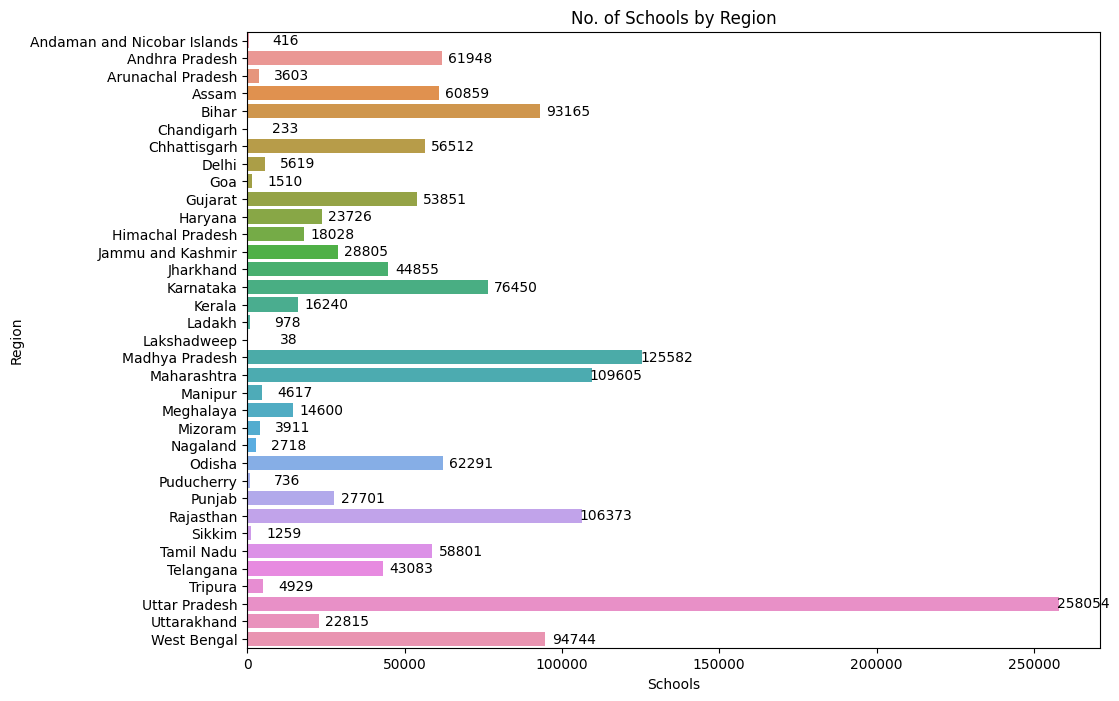

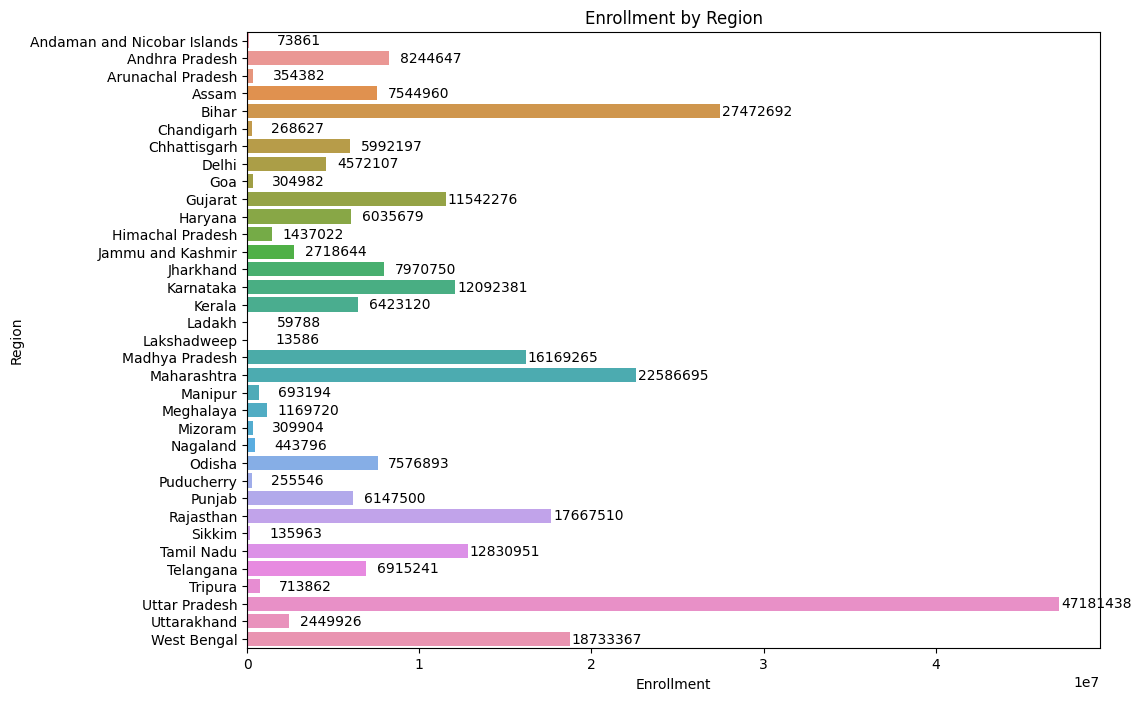

In [ ]:
# Bar Plot: No. of Schools by Region
plt.figure(figsize=(11, 8))
sns.barplot(x='Total', y='India/ State /UT', data=final_set.drop(index=0))
plt.title('No. of Schools by Region')
plt.xlabel('Schools')
plt.ylabel('Region')
for index, value in enumerate(final_set.drop(index=0)['Total']):
    plt.text(value+16000, index, f'{value}', ha='right', va='center', color='black', fontsize=10)
plt.show()

# Bar Plot: Total Enrollment by Region
plt.figure(figsize=(11, 8))
sns.barplot(x='Enrollment', y='India/ State /UT', data=final_set.drop(index=0))
plt.title('Enrollment by Region')
plt.xlabel('Enrollment')
plt.ylabel('Region')
for index, value in enumerate(final_set.drop(index=0)['Enrollment']):
    plt.text(value+4200000, index, f'{value}', ha='right', va='center', color='black', fontsize=10)
plt.show()

***Summary of Schools and Enrollment by Indian States and UTs***

The dataset provides information on the total number of schools and the corresponding enrollment figures across various states and Union Territories (UTs) in India. Here’s a brief analysis:

**Overall Summary:**

India has a total of 1,489,115 schools with a combined enrollment of 265,235,830 students.
Uttar Pradesh has the highest number of schools, totaling 258,054, with an enrollment of 47,181,438 students.
Madhya Pradesh follows with 125,582 schools and an enrollment of 16,169,265 students.
Maharashtra has 109,605 schools and 22,586,695 students enrolled.
Lakshadweep has the smallest number of schools at just 38, with an enrollment of 13,586 students.
Sikkim and Chandigarh also have relatively few schools, with 1,259 and 233 schools respectively.

There is a clear disparity in the number of schools and enrollment figures across different states, influenced by regional population size, educational policies, and infrastructure development.
States with fewer schools but high enrollment may indicate higher student-to-school ratios, which could reflect on the quality and accessibility of education.

## Analysing the Education Metrics across India

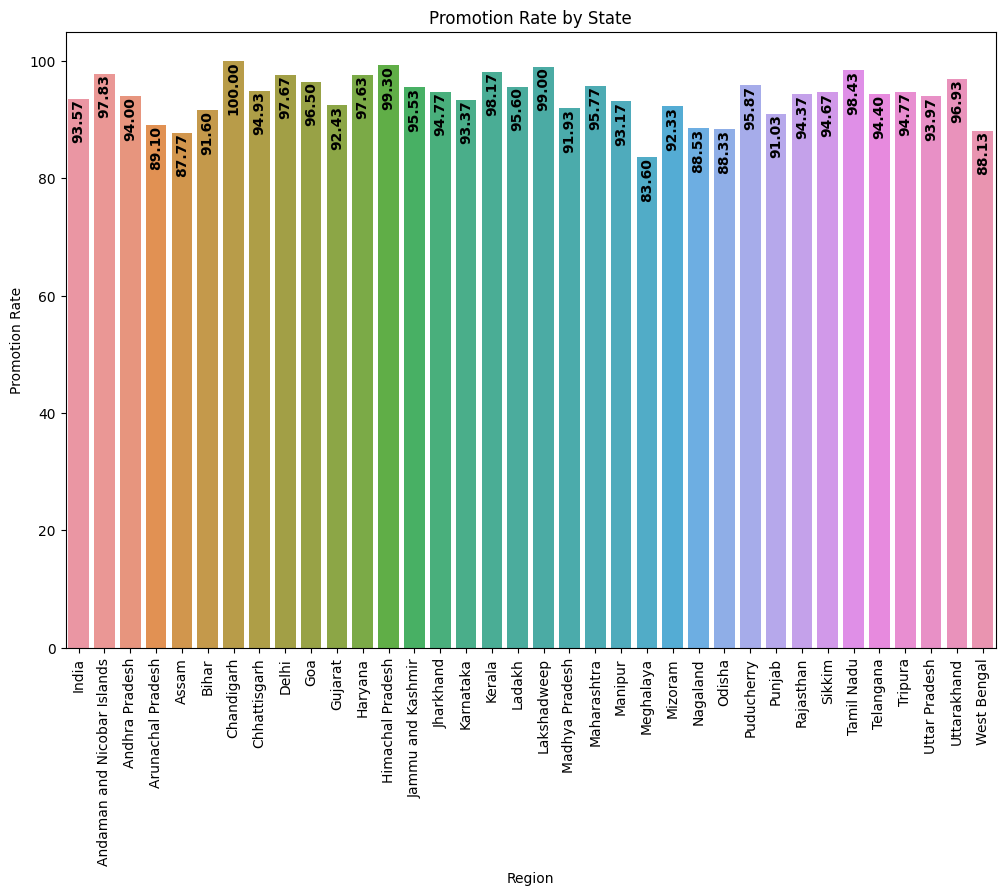

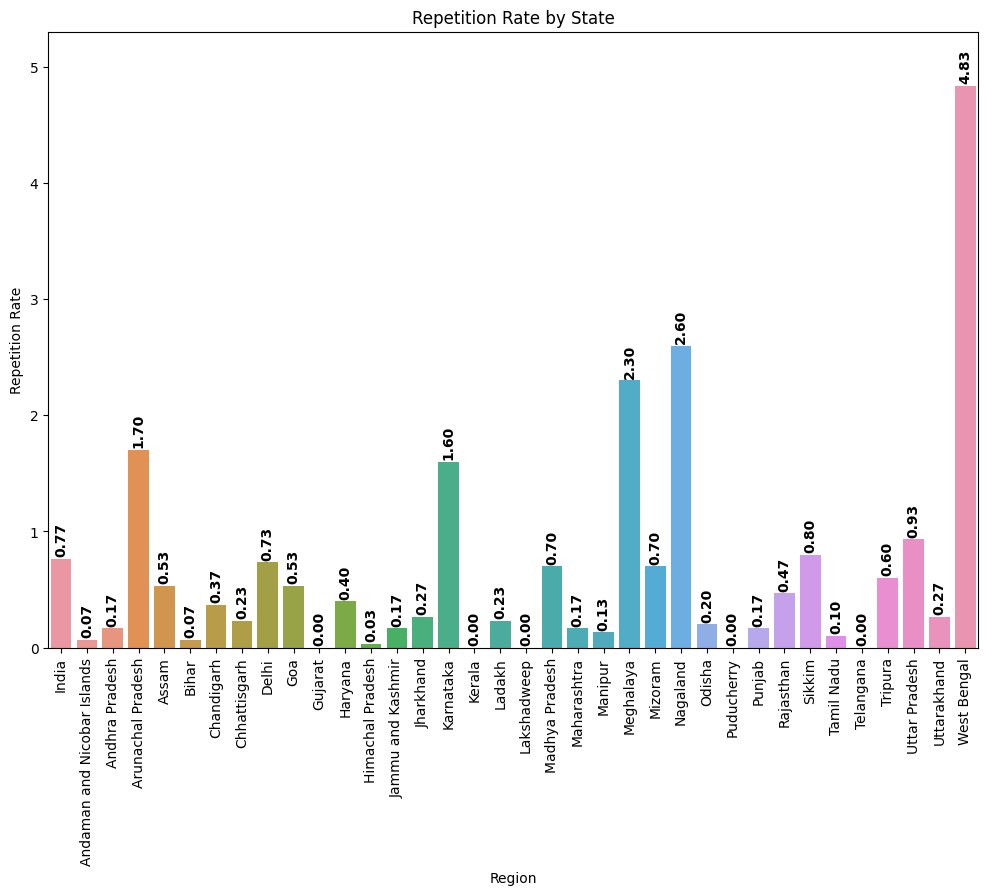

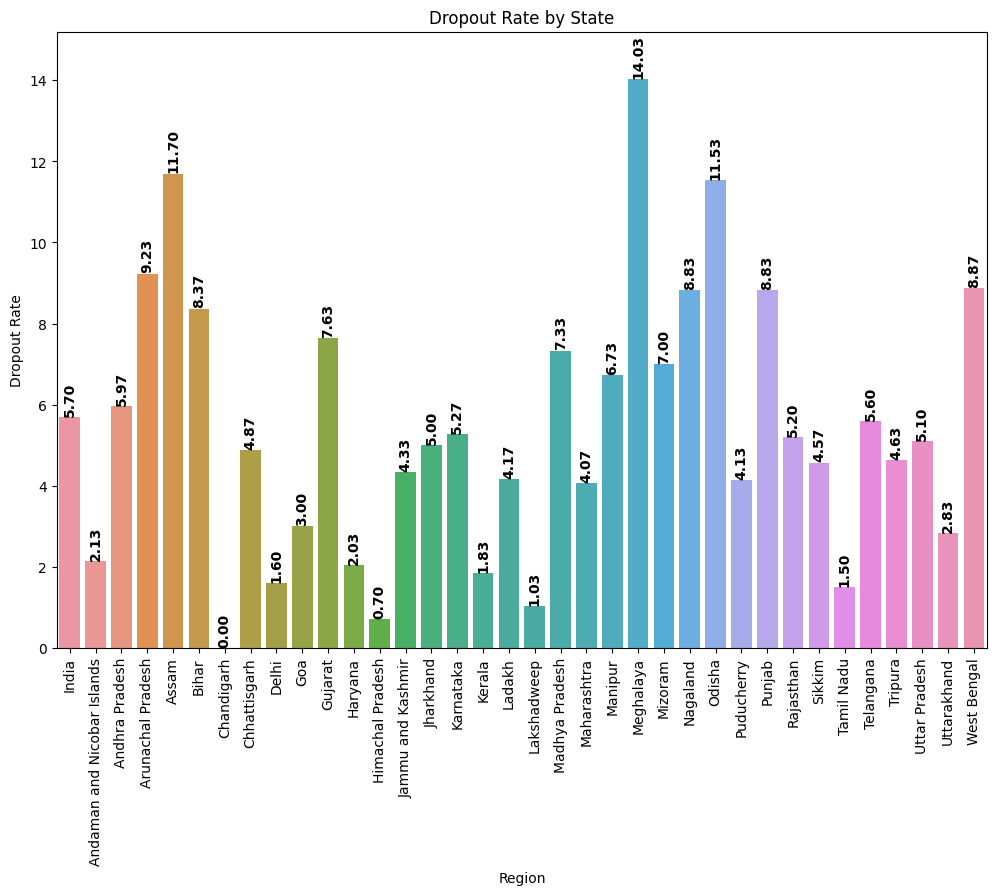

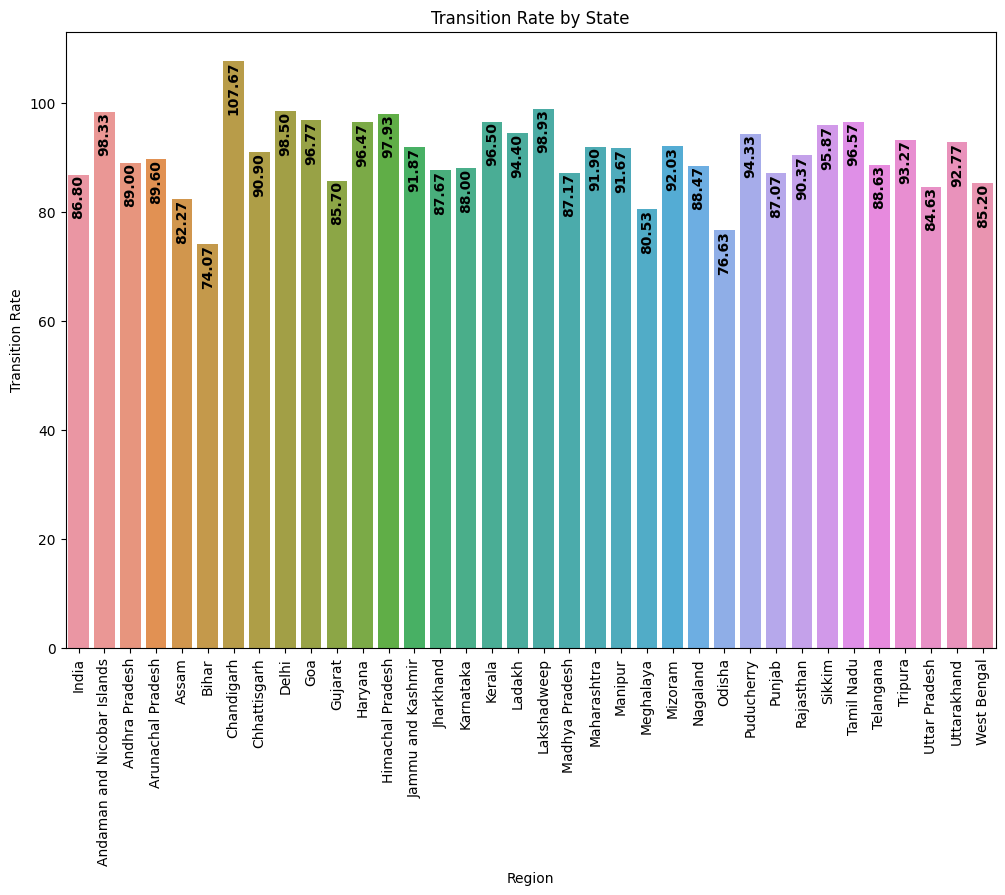

In [ ]:
# Bar Plot: Promotion by Region
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='India/ State /UT', y='Promotion Rate', data=final_set)
plt.title('Promotion Rate by State')
plt.xlabel('Region')
plt.ylabel('Promotion Rate')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='top',
                fontsize=10, color='black', weight='bold',rotation=90)
plt.show()

# Bar Plot: Repetition by Region
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='India/ State /UT', y='Repetition Rate', data=final_set)
plt.title('Repetition Rate by State')
plt.xlabel('Region')
plt.ylabel('Repetition Rate')
plt.xticks(rotation=90)
ax.set_ylim(0, 5.3)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()+0.02),
                ha='center', va='bottom',
                fontsize=10, color='black', weight='bold',rotation=90)
plt.show()

# Bar Plot: Dropout by Region
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='India/ State /UT', y='Dropout Rate', data=final_set)
plt.title('Dropout Rate by State')
plt.xlabel('Region')
plt.ylabel('Dropout Rate')
plt.xticks(rotation=90)
ax.set_ylim(0, 15.2)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()+0.02),
                ha='center', va='bottom',
                fontsize=10, color='black', weight='bold',rotation=90)
plt.show()

# Bar Plot: Transition by Region
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='India/ State /UT', y='Transition Rate', data=final_set)
plt.title('Transition Rate by State')
plt.xlabel('Region')
plt.ylabel('Transition Rate')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='top',
                fontsize=10, color='black', weight='bold',rotation=90)

plt.show()

***Summary of Educational Metrics by Indian States and UTs***

The dataset provides key educational metrics for various states and Union Territories (UTs) in India, including the Promotion Rate, Dropout Rate, Transition Rate, and Repetition Rate. Here's a comprehensive summary:

**Overall Metrics:**

1. Promotion Rate: Average of 93.57%, reflecting the percentage of students advancing to the next grade.
2. Dropout Rate: Average of 5.7%, indicating the percentage of students who leave school before completion.
3. Transition Rate: Average of 86.8%, showing the percentage of students transitioning to the next educational level.
4. Repetition Rate: Average of 0.77%, representing the percentage of students repeating a grade.

**Promotion Rate Insights:**

* Chandigarh has a perfect promotion rate of 100%.
* Kerala and Tamil Nadu also show high promotion rates of 98.17% and 98.43%, respectively.
* Himachal Pradesh and Lakshadweep have promotion rates of 99.3% and 99%.
* Meghalaya has the lowest promotion rate at 83.6%.
* West Bengal and Odisha follow with 88.13% and 88.33%, respectively.

**Dropout Rate Insights:**

* Meghalaya has the highest dropout rate at 14.03%.
* Assam and West Bengal also report high dropout rates of 11.7% and 8.87%, respectively.
* Himachal Pradesh and Chandigarh have very low dropout rates, 0.7% and 0%.

**Transition Rate Insights:**

* Chandigarh has an exceptionally high transition rate of 107.67%, which might indicate additional factors like data reporting or cross-state transitions.
* Kerala and Tamil Nadu also have high transition rates of 96.5% and 96.57%, respectively.
* Assam and West Bengal have lower transition rates of 82.27% and 85.2%, respectively.

**Repetition Rate Insights:**

* West Bengal has the highest repetition rate at 4.83%.
* Nagaland and Meghalaya also show relatively high repetition rates of 2.6% and 2.3%, respectively.
* Tamil Nadu and Himachal Pradesh have very low repetition rates of 0.1% and 0.03%, respectively.

**Regional Trends:**

* Southern India states such as Kerala, Tamil Nadu, and Goa generally show high promotion rates and low dropout rates, indicating strong educational performance.
* Northern and Northeastern India states like Meghalaya and Nagaland report higher dropout and repetition rates, highlighting potential areas for improvement.
* Central India states like Madhya Pradesh and Uttar Pradesh have moderate metrics, reflecting a balance between performance and challenges.

**Disparities and Opportunities:**

* The data shows significant variability in educational outcomes across states, with some regions excelling in promotion rates while others struggle with higher dropout and repetition rates.
* States with lower dropout rates and higher promotion rates, such as Chandigarh and Kerala, can serve as models for educational success.
* States with higher dropout and repetition rates may benefit from targeted interventions and educational reforms to improve student retention and success.

## Analysing the Facilities Coverage across India

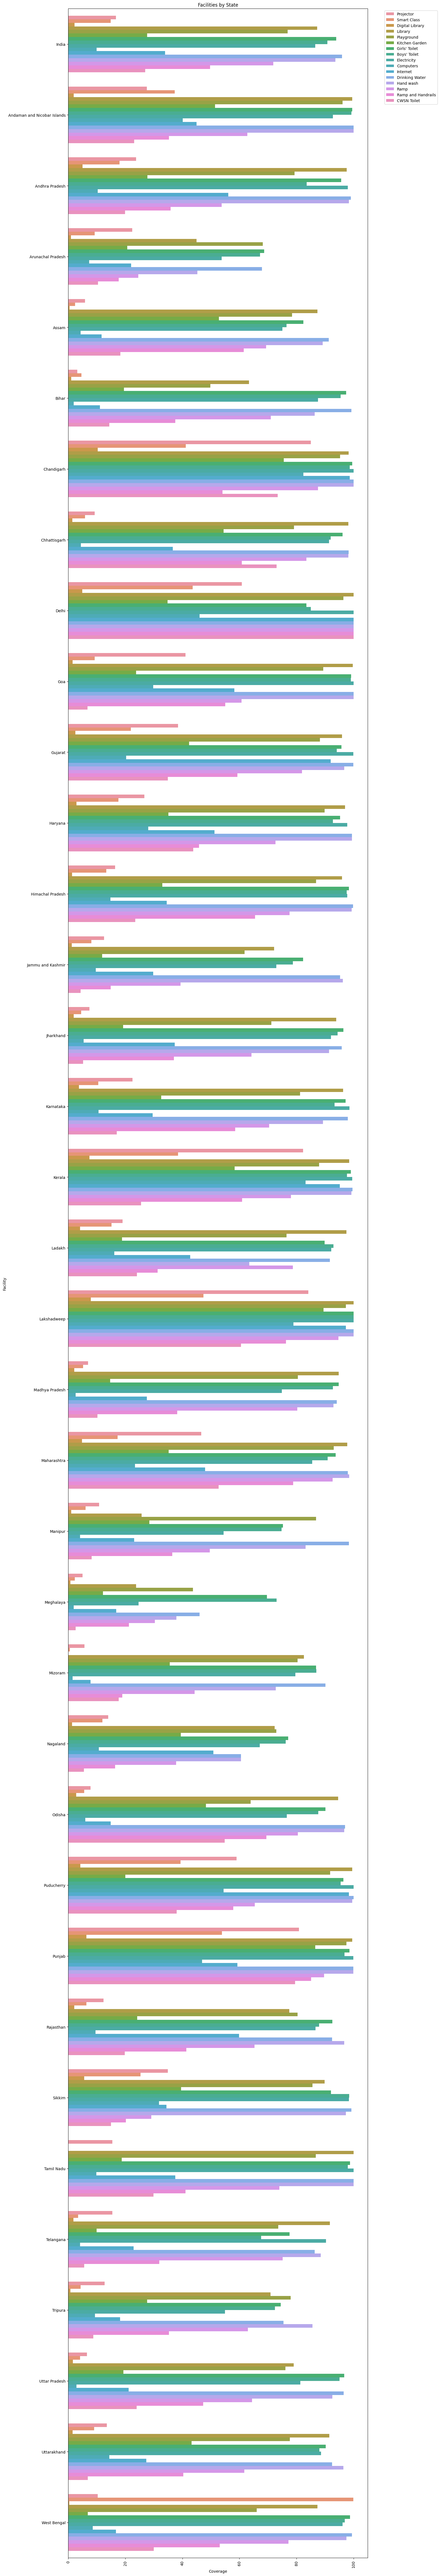

In [ ]:
# Stacked Bar Graph: Facilities Coverage by different states and UTs
facilities_coverage = final_set.drop(final_set.columns[[1,2,3,4,5,6]],axis=1).melt(id_vars='India/ State /UT', var_name='Facility', value_name='Coverage')

plt.figure(figsize=(14, 120))
ax = sns.barplot(x='Coverage', y='India/ State /UT', hue='Facility', data=facilities_coverage,dodge=True)
plt.title('Facilities by State')
plt.xlabel('Coverage')
plt.ylabel('Facility')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

***Summary of Facility Availability in Indian Schools***

The dataset provides information on the availability of various facilities in schools across Indian states and Union Territories (UTs). The metrics include the percentage of schools equipped with facilities such as *Projectors, Smart Classes, Digital Libraries, Libraries, Playgrounds, Kitchen Gardens, Girls' Toilets, Boys' Toilets, Electricity, Computers, Internet, Drinking Water, Hand Wash Stations, Ramps, Ramps and Handrails, and CWSN (Children with Special Needs) Toilets.*

**Basic Facility Availability:**

* Drinking Water is widely available with an average of 95.9%, reflecting good access to basic hydration needs.
* Electricity is present in an average of 86.6% of schools, which is critical for modern education.
* Girls' Toilets and Boys' Toilets have high availability, 93.9% and 90.9% respectively, indicating a strong focus on basic sanitation.
* Hand Wash Stations are available in 93.6% of schools, promoting hygiene practices among students.
* Libraries are highly available across states, with an average availability of 87.3%. Many states like Chandigarh, Delhi, and Goa have near-total availability.

**Variability in Advanced Facilities:**

* Smart Classes and Projectors show significant variability, with Delhi and Chandigarh leading in these advanced facilities, whereas states like Bihar and Jharkhand have much lower percentages.
* Digital Libraries are relatively rare, with an average availability of only 2.2%, indicating a potential area for development.
* Computers are available in 33.9% of schools, and Internet access is slightly higher at 33.9%. This indicates room for improvement in integrating technology into the educational environment.

**Playground and Kitchen Gardens:**

* Playgrounds are available in 77% of schools on average, which is relatively high but varies significantly between states.
* Kitchen Gardens are present in 27.6% of schools, showing a moderate commitment to promoting nutrition and environmental education.

**Accessibility Features:**

* Ramps are present in 49.7% of schools, and Ramps and Handrails are available in 71.8%. These features are crucial for ensuring accessibility for children with disabilities.
* On average, 49.7% of Indian schools have CWSN (Children with Special Needs) toilets. Delhi and Chandigarh lead in availability, while Assam and Bihar lag behind, highlighting the need for improved accessibility in many areas.

**State-Specific Highlights:**

* Chandigarh stands out with high availability across most categories, particularly in Projectors, Smart Classes, Libraries, and Digital Libraries.
* West Bengal shows exceptionally high availability of Playgrounds (99.9%) but less availability of Smart Classes and Digital Libraries.
* Madhya Pradesh and Uttar Pradesh have lower availability of advanced facilities but maintain good basic infrastructure.
* States like Assam, Bihar, and Meghalaya have lower percentages in advanced facilities such as Smart Classes and Projectors but maintain a decent level of basic amenities.

**Conclusions:**
* There is a considerable disparity in the availability of educational facilities across different states and UTs.
* While basic facilities such as libraries, drinking water, and sanitation are broadly available, advanced facilities like smart classes and digital libraries are less common, suggesting areas where infrastructure could be enhanced.
* States like Delhi, Chandigarh, and Kerala show higher levels of facility availability and could serve as models for improving educational infrastructure.

## Analysing the impact of each facility

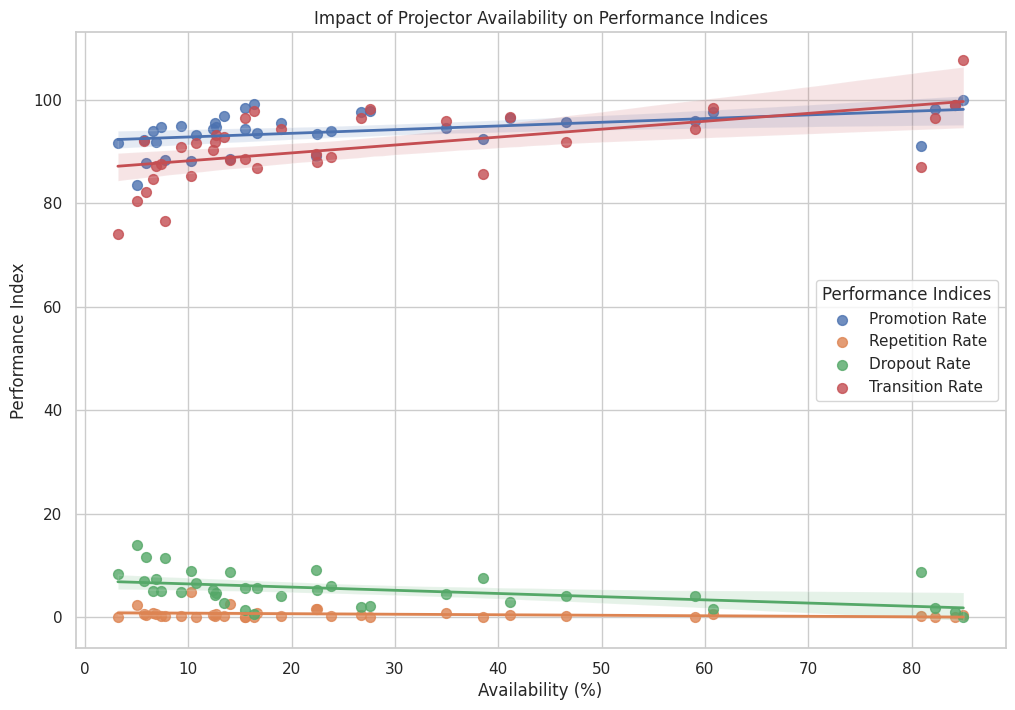

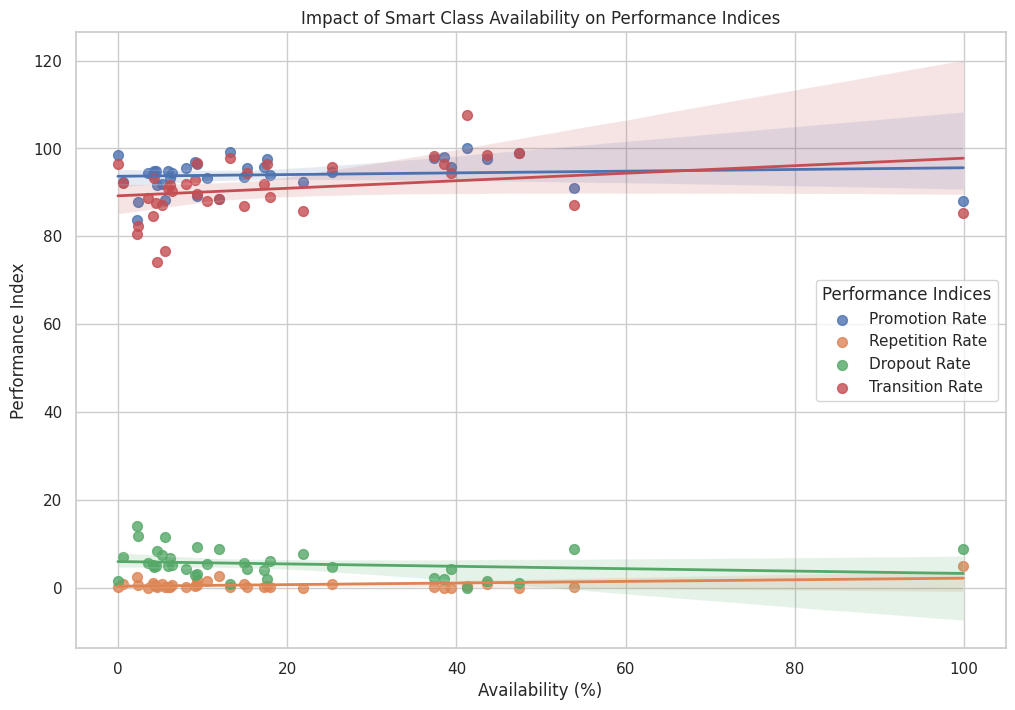

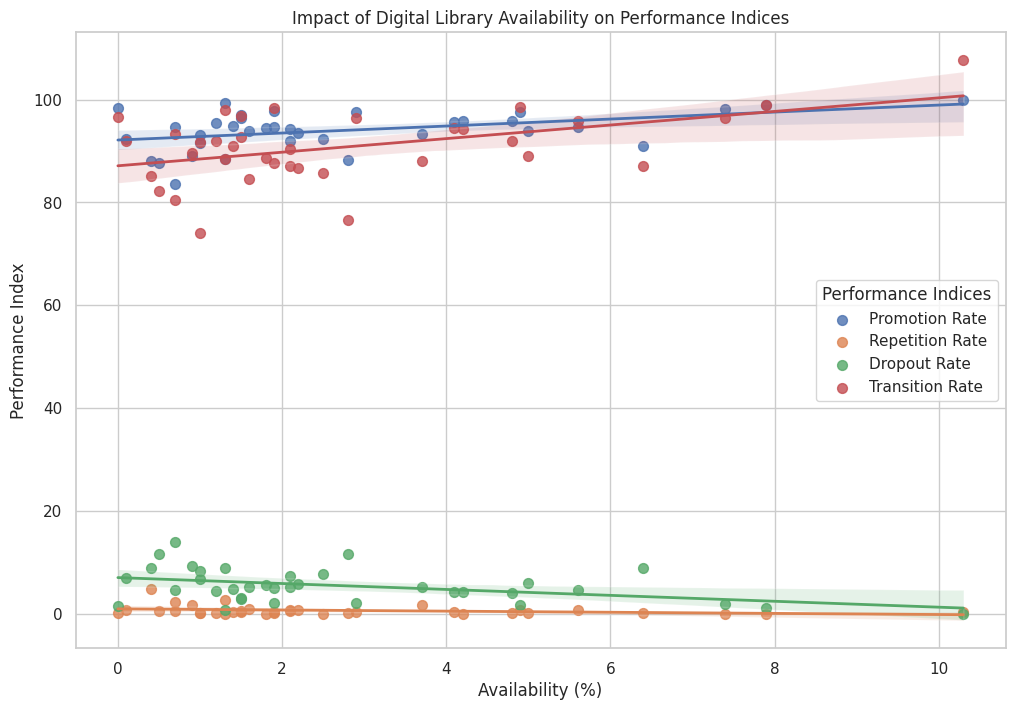

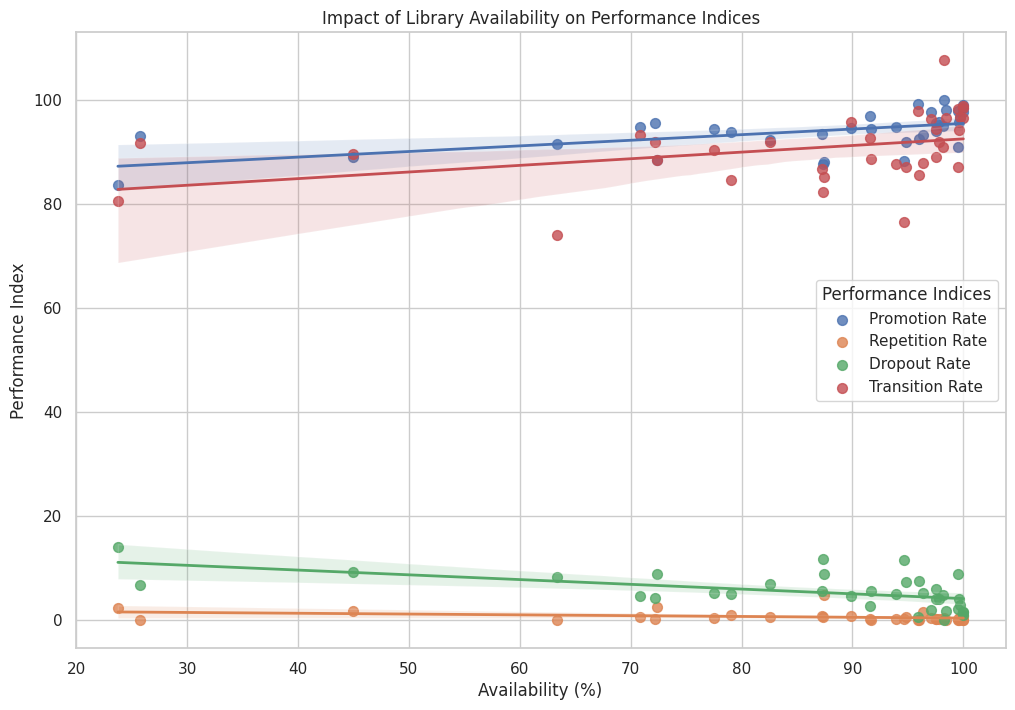

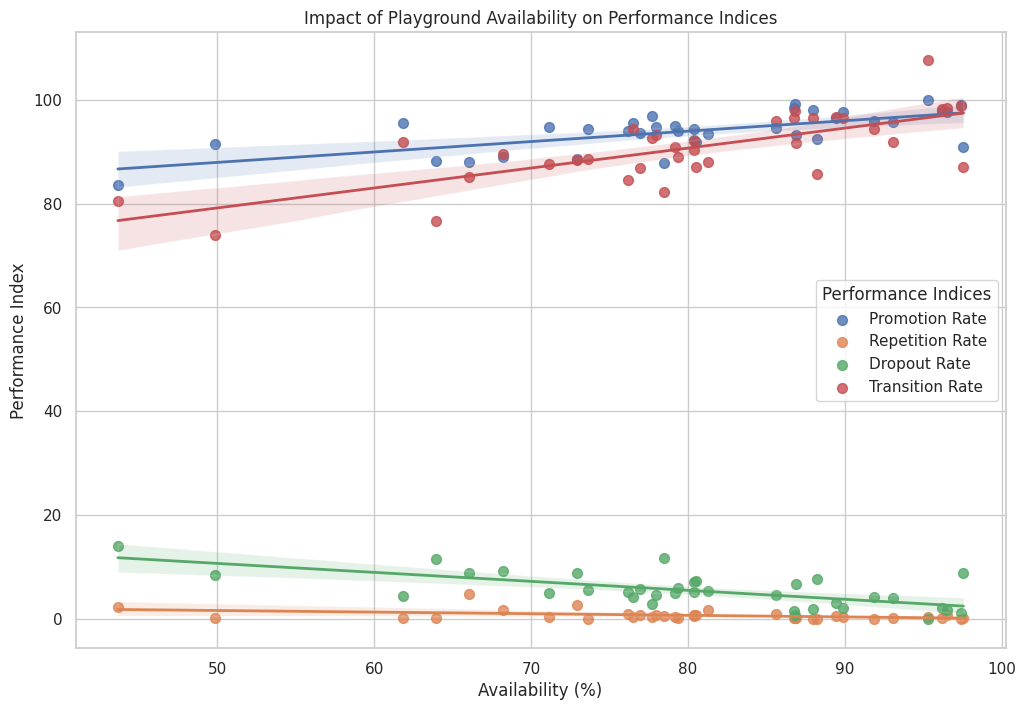

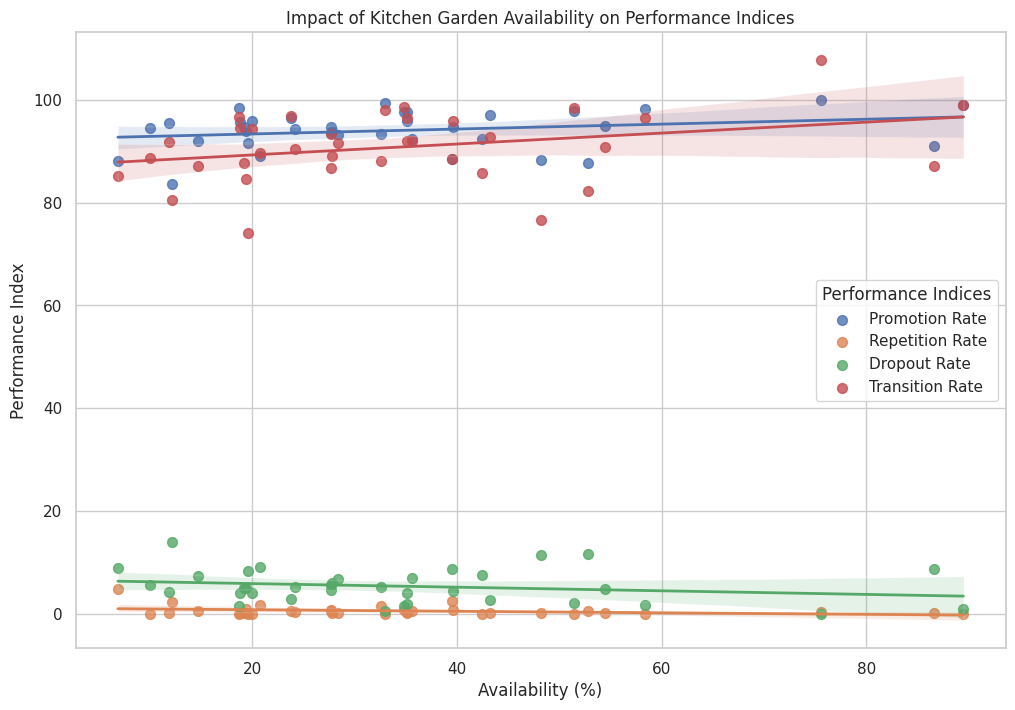

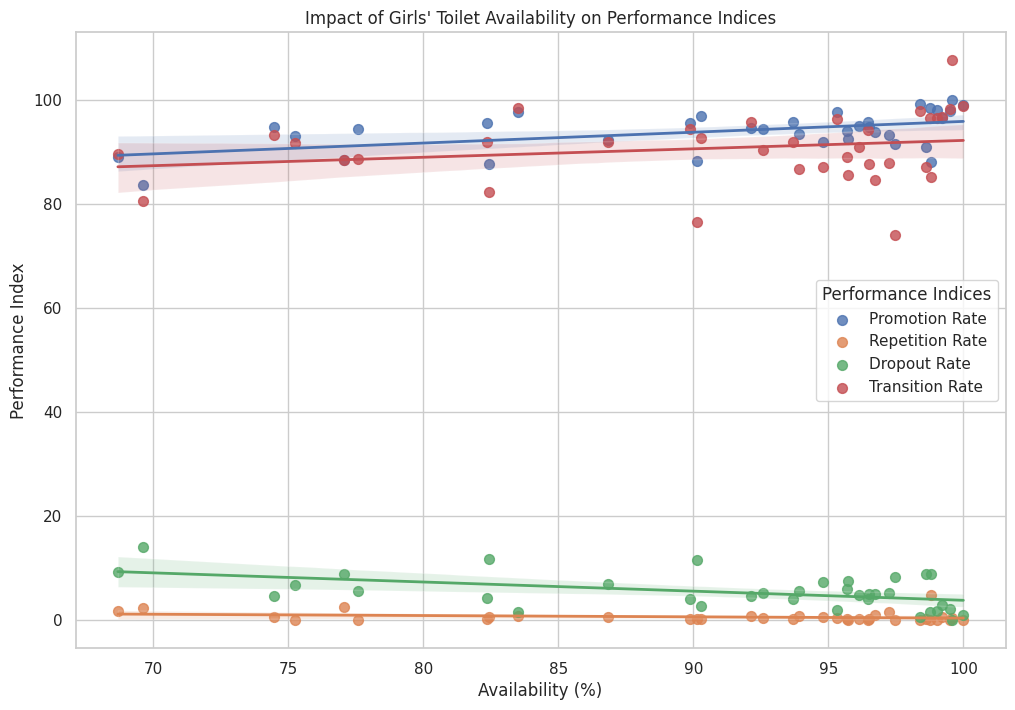

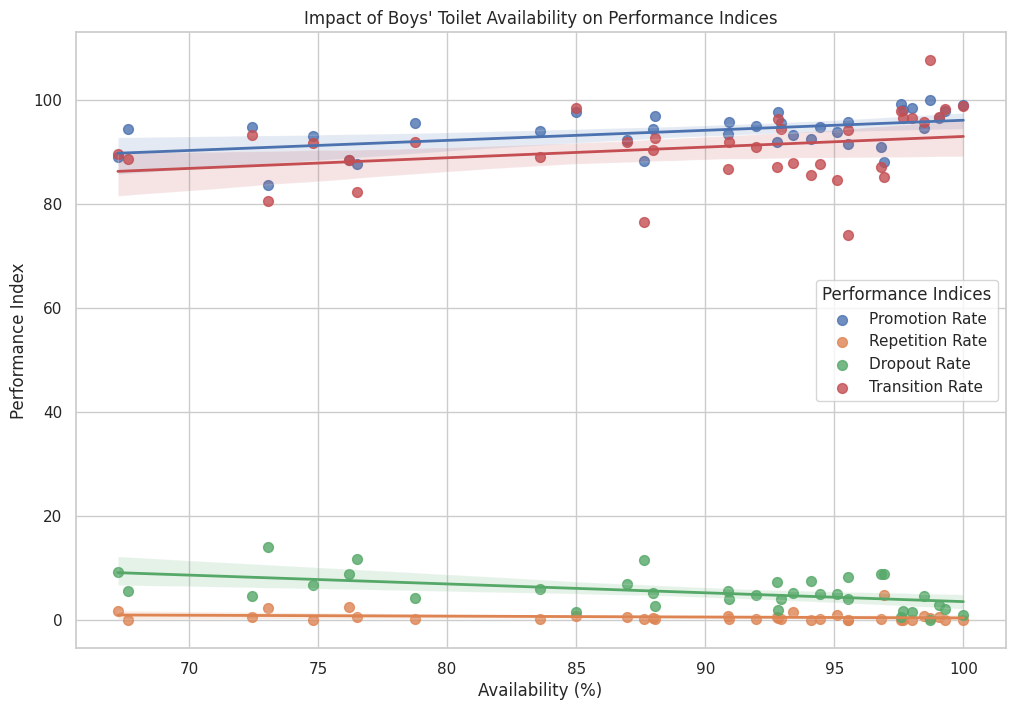

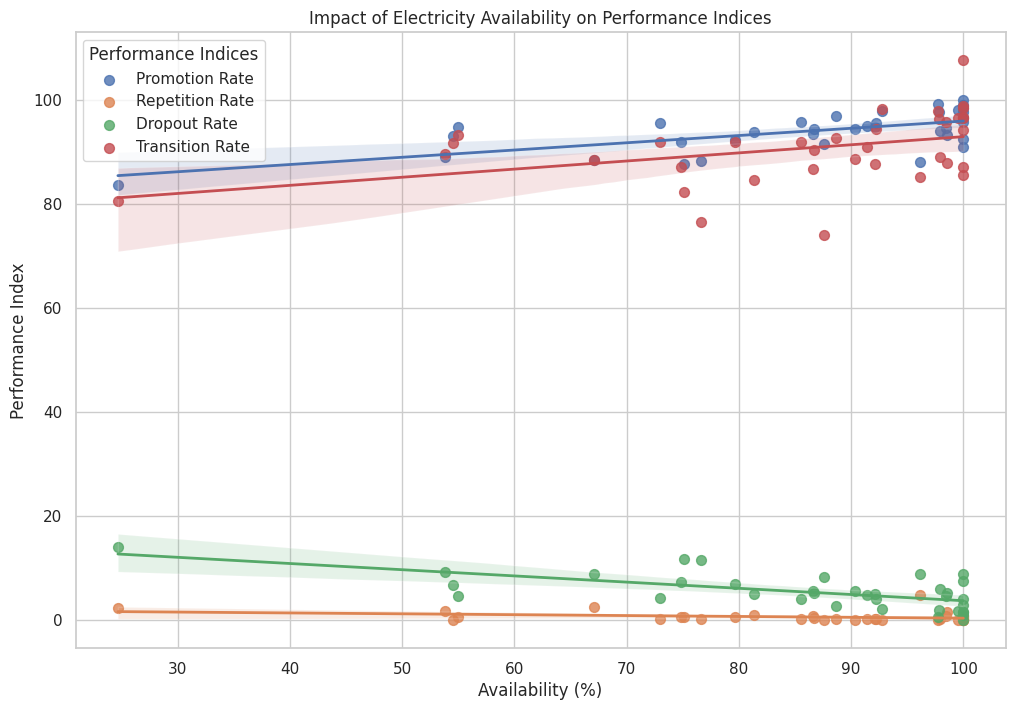

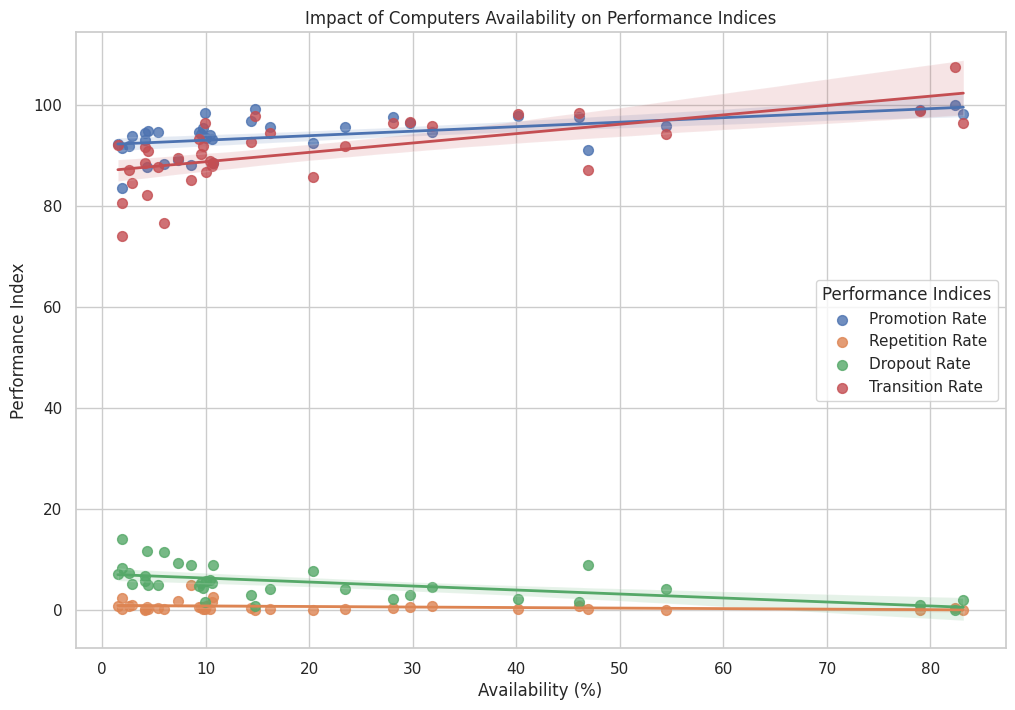

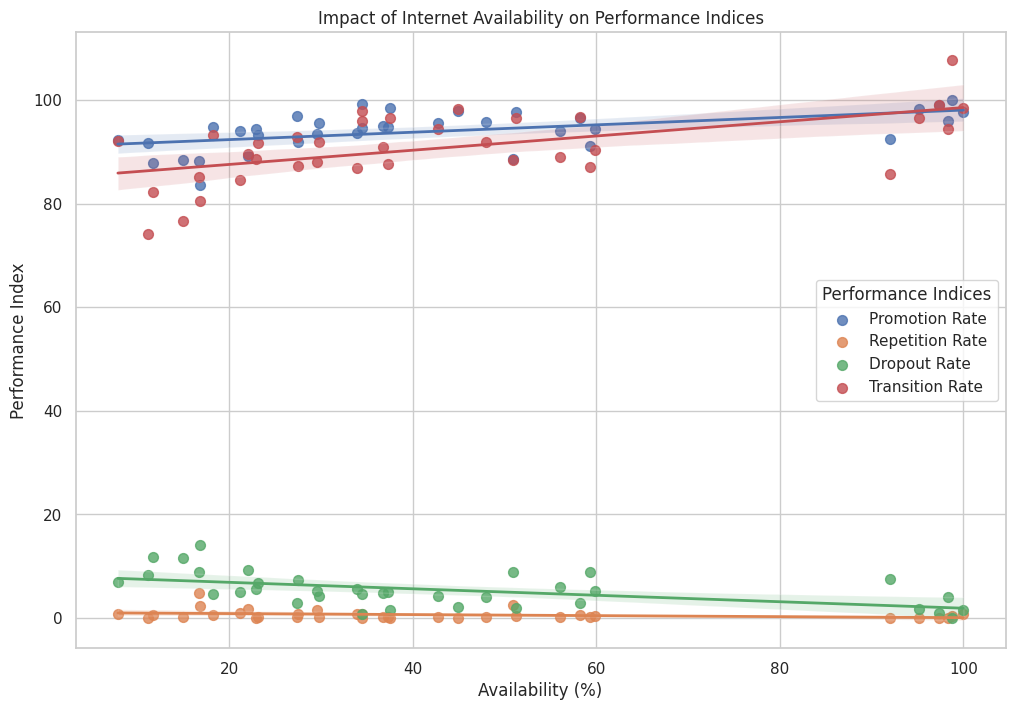

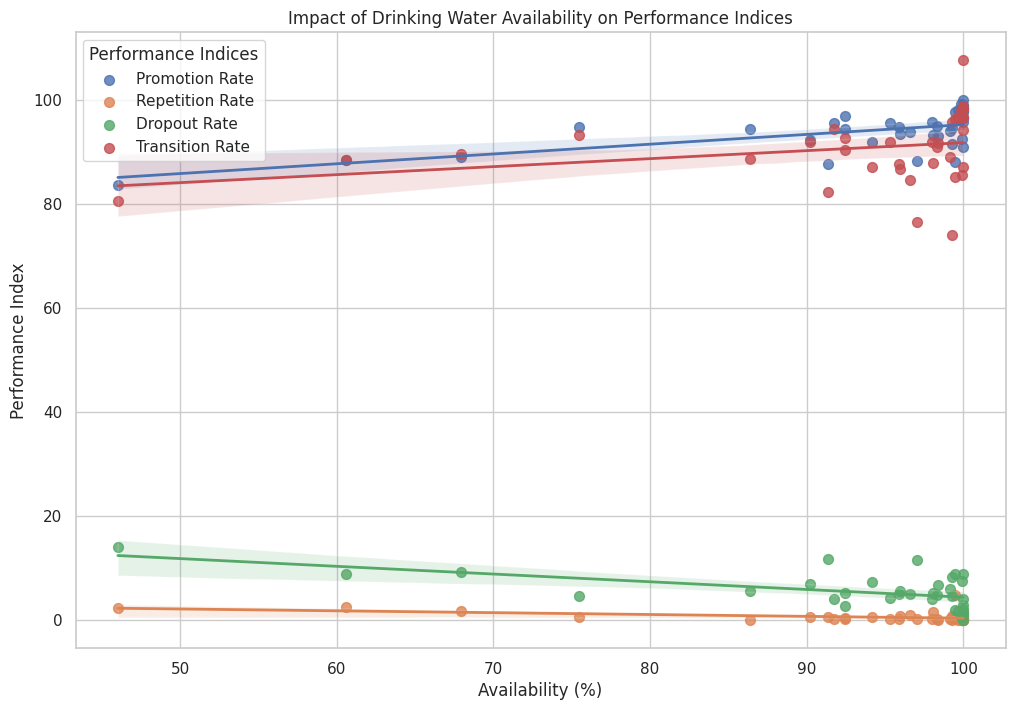

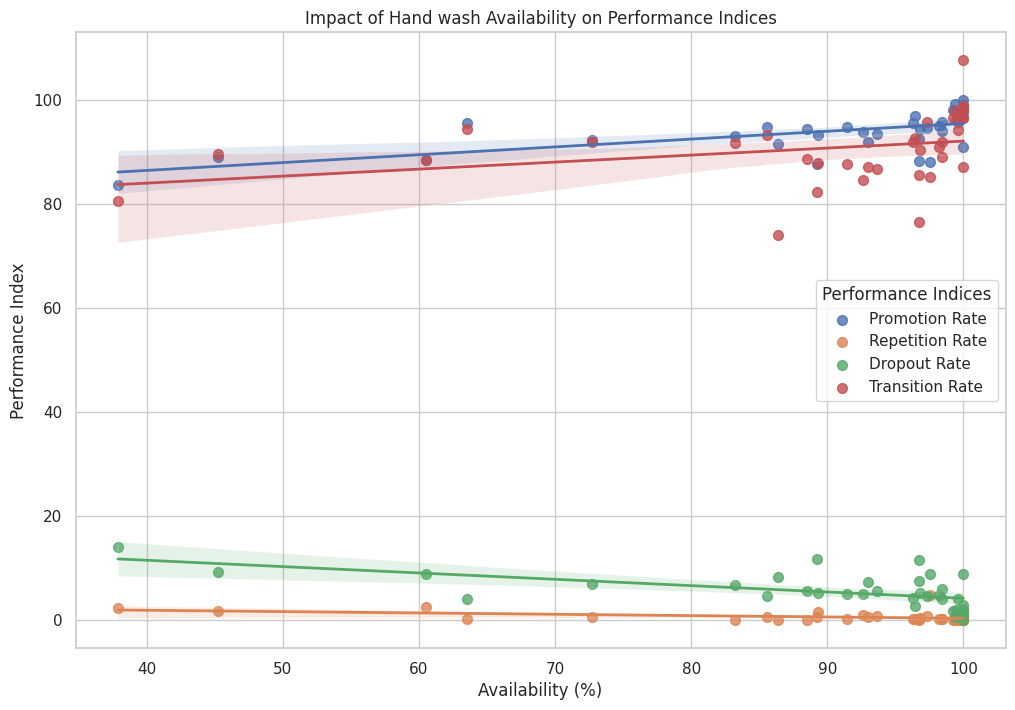

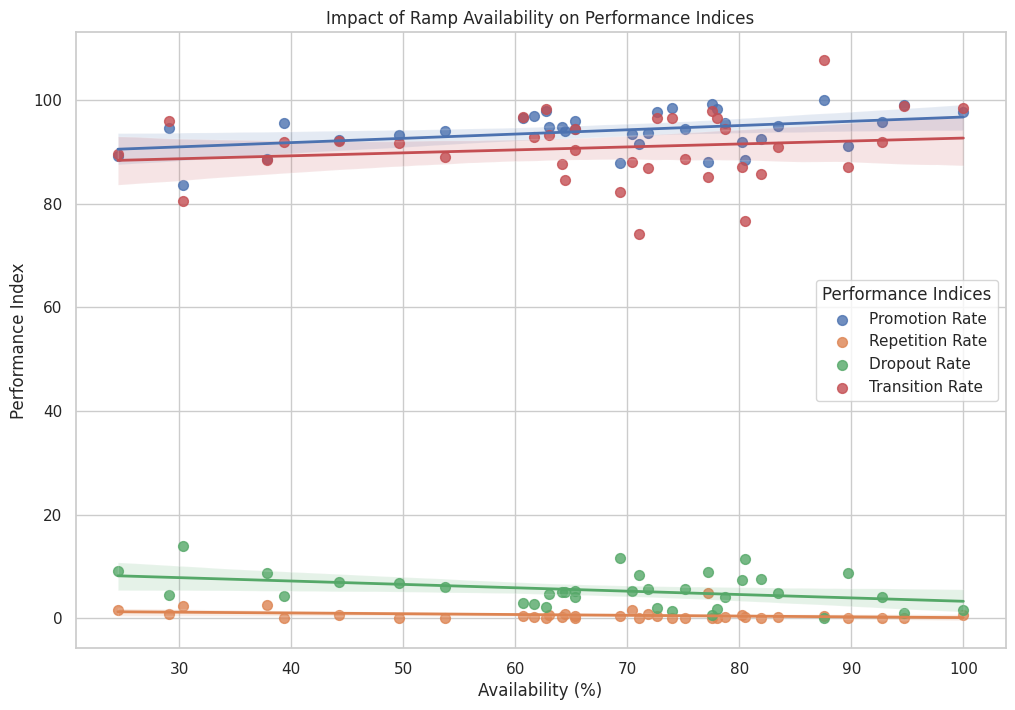

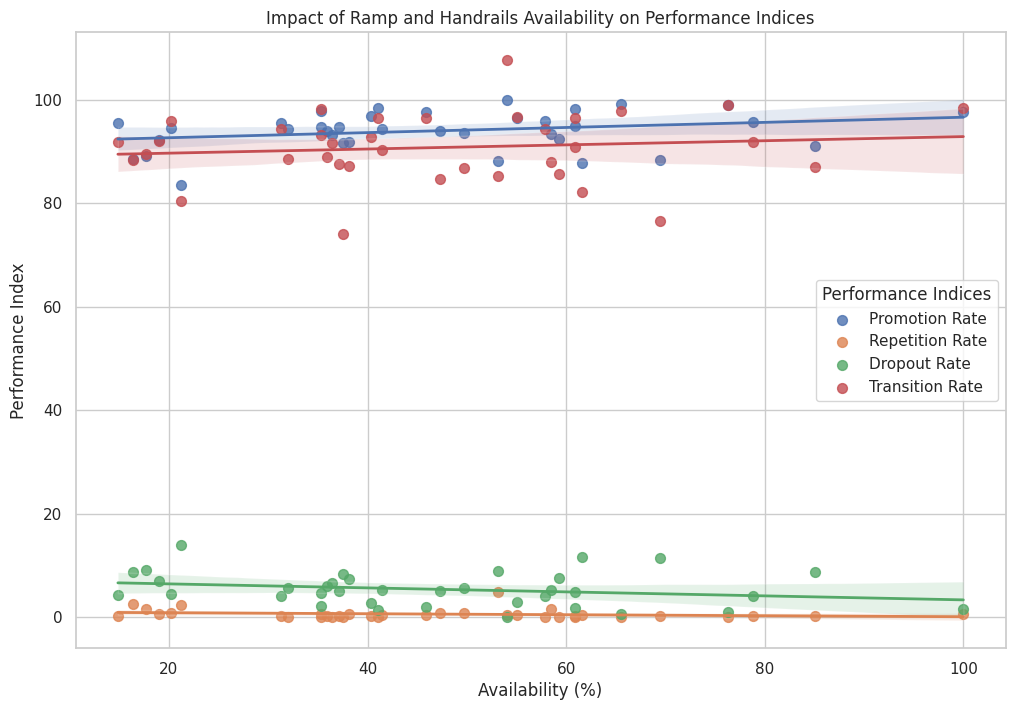

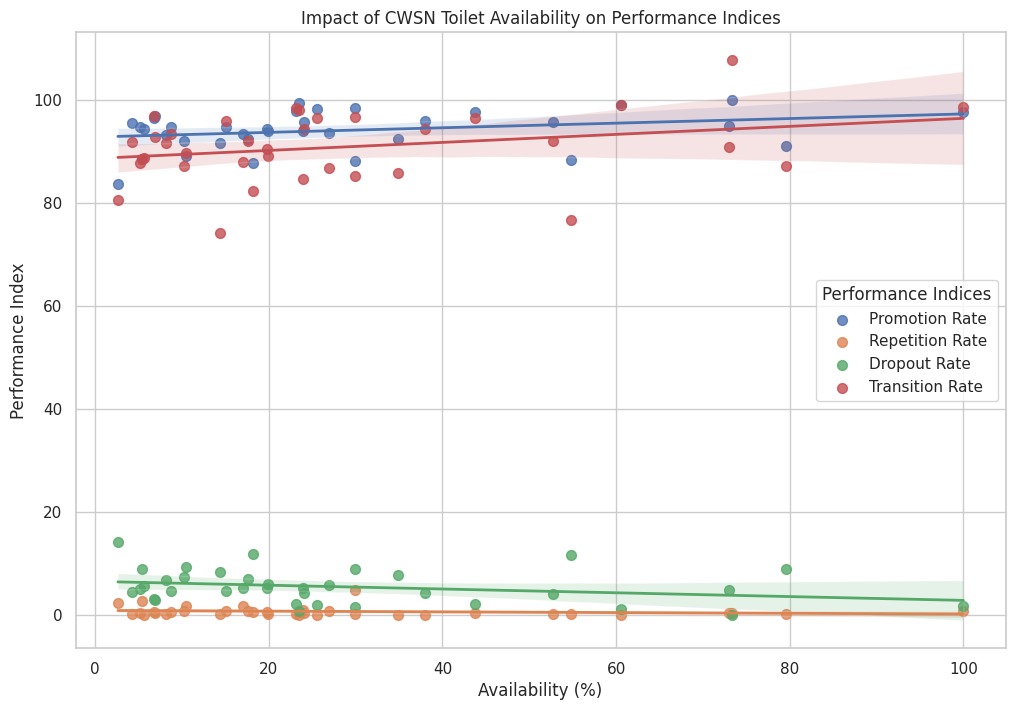

In [ ]:
# Scatter Plot with Regression Line: Impact of Facility Availability on Performance Indices
sns.set(style="whitegrid")
performance_indices = ['Promotion Rate', 'Repetition Rate', 'Dropout Rate', 'Transition Rate']
facilities=['Projector','Smart Class','Digital Library','Library','Playground','Kitchen Garden',"Girls' Toilet","Boys' Toilet","Electricity",'Computers','Internet','Drinking Water','Hand wash','Ramp','Ramp and Handrails','CWSN Toilet']
for facility in facilities:
    plt.figure(figsize=(12, 8))
    for index in performance_indices:
        sns.regplot(x=facility, y=index, data=final_set, label=index, scatter_kws={'s':50}, line_kws={'linewidth':2})
    plt.title(f'Impact of {facility} Availability on Performance Indices')
    plt.xlabel('Availability (%)')
    plt.ylabel('Performance Index')
    plt.legend(title='Performance Indices')
    plt.show()

***Impact of Overall Facility Availability on Educational Performance Indices***

Increased availability of educational(Infrastructural as well as Technological) facilities generally correlates with improved performance metrics across various indices:

1. **Promotion Rate**: Schools with more comprehensive facilities typically achieve higher promotion rates, indicating better student progression through grades.
2. **Dropout Rate**: Higher facility availability is often associated with lower dropout rates, suggesting that well-equipped schools enhance student retention.
3. **Transition Rate**: Schools with a greater range of facilities tend to have higher transition rates, reflecting smoother student advancement between educational stages.
4. **Repetition Rate**: Enhanced facility availability generally correlates with lower repetition rates, signifying fewer students repeating grades.

## Analysis and Recommendations on Current Scenario of Infratech Facilities

**1. Projector and Smart Classrooms**

*Current Statistics:*

* Projectors: Ranges from 3.2% in Bihar to 85% in Chandigarh.
* Smart Classes: Ranges from 0% in Tamil Nadu to 99.9% in West Bengal.

*Impact on Quality Education:*

Projectors and smart classes enhance interactive learning and can significantly improve engagement and comprehension.
High availability in states like Chandigarh and West Bengal suggests better technology adoption and potential for improved student outcomes.

*Suggestions for Improvement:*

* Increase Adoption: Invest in technology infrastructure in states with low percentages (e.g., Bihar, Tamil Nadu).
* Training: Provide training for teachers on effective use of projectors and smart classes to maximize benefits.

**2. Digital Libraries and Libraries**

*Current Statistics:*

* Digital Libraries: Ranges from 0.1% in Mizoram to 10.3% in Chandigarh.
* Libraries: Ranges from 23.75% in Meghalaya to 100% in Delhi and Lakshadweep.

*Impact on Quality Education:*

Digital libraries and physical libraries provide essential resources for research, reading, and self-learning, which support academic achievement and foster independent study habits.

*Suggestions for Improvement:*

* Expand Resources: Increase investment in digital and physical library resources in states with low coverage.
* Promote Usage: Implement programs to encourage students to utilize library resources effectively.

**3. Playground and Kitchen Gardens**

*Current Statistics:*

* Playgrounds: Ranges from 44.99% in Arunachal Pradesh to 100% in Delhi and Lakshadweep.
* Kitchen Gardens: Ranges from 6.85% in West Bengal to 75.54% in Chandigarh.

*Impact on Quality Education:*

Playgrounds support physical development and social skills. Kitchen gardens offer experiential learning opportunities and promote healthy eating habits.

*Suggestions for Improvement:*

* Enhance Facilities: Develop or improve playgrounds and kitchen gardens, especially in states with low availability (e.g., Arunachal Pradesh, West Bengal).
* Integrate Learning: Use kitchen gardens as part of the curriculum to teach students about agriculture and nutrition.

**4. Toilets (Girls', Boys', and CWSN)**

*Current Statistics:*

* Girls' Toilets: Ranges from 49.72% in India to 100% in several states.
* Boys' Toilets: Ranges from 37.51% in Bihar to 100% in several states.
* CWSN Toilets: Ranges from 16.41% in Nagaland to 100% in states like Delhi and Lakshadweep.

*Impact on Quality Education:*

Adequate sanitation facilities are critical for maintaining student health and attendance. CWSN toilets are essential for inclusive education for children with special needs.

*Suggestions for Improvement:*

* Upgrade Facilities: Ensure all schools have sufficient and functional sanitation facilities.
* Focus on Inclusivity: Prioritize the installation and maintenance of CWSN toilets to support children with special needs.

**5. Electricity, Computers, and Internet**

*Current Statistics:*

* Electricity: Ranges from 74.8% in Madhya Pradesh to 100% in several states.
* Computers: Ranges from 1.9% in Bihar to 86.84% in Chandigarh.
* Internet: Ranges from 1.9% in Bihar to 100% in states like Delhi and Lakshadweep.

*Impact on Quality Education:*

Electricity, computers, and internet access are fundamental for digital learning and integration of technology in education.

*Suggestions for Improvement:*

* Infrastructure Development: Invest in improving electricity supply and expand computer and internet access in underserved states.
* Digital Literacy: Provide training for students and teachers on using computers and internet resources effectively.

**6. Drinking Water, Hand Wash Stations, and Ramps**

*Current Statistics:*

* Drinking Water: Ranges from 24.66% in Meghalaya to 100% in states like Delhi and Lakshadweep.
* Hand Wash Stations: Ranges from 1.89% in Meghalaya to 100% in several states.
* Ramps: Ranges from 6.9% in Manipur to 100% in states like Delhi and Lakshadweep.

*Impact on Quality Education:*

Safe drinking water, hand wash stations, and ramps are crucial for health, hygiene, and accessibility. These facilities are essential for creating a conducive learning environment.

*Suggestions for Improvement:*

* Health and Accessibility: Ensure all schools are equipped with basic health and accessibility facilities, especially in states with lower percentages.
* Regular Maintenance: Implement regular checks and maintenance of these facilities to ensure they remain functional and effective.

**Overall Recommendations**

* Prioritize Infrastructure: Focus on states with low availability of critical facilities and invest in upgrading infrastructure.
* Implement Training Programs: Provide professional development for teachers and staff to maximize the impact of new technologies and facilities.
* Promote Inclusivity: Ensure all facilities support inclusive education, particularly for students with special needs.
* Monitor and Evaluate: Continuously monitor the availability and condition of facilities and adjust policies and investments as needed.
* By addressing these areas, educational outcomes can be significantly improved, leading to better student performance, engagement, and motivation across different states and UTs.

## Analysing the correlation among facilities and education metrics

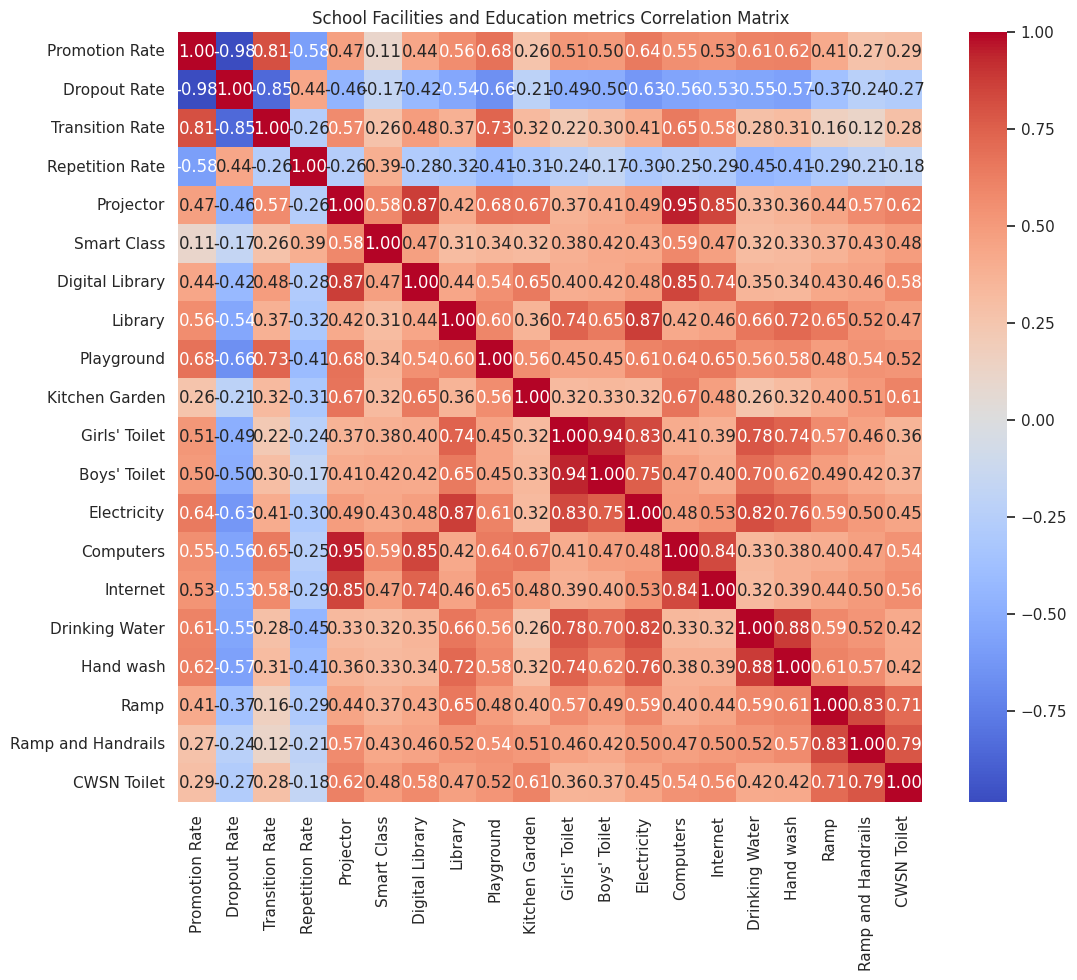

In [ ]:
# Compute the correlation matrix
correlation_matrix = final_set.drop(final_set.columns[[0,1,2]],axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('School Facilities and Education metrics Correlation Matrix')
plt.show()


***Analaysing the Correlation of facilities and the performance metrics***

**Facilities with Limited Impact on Student Performance and Quality Education**

While a variety of facilities contribute to the quality of education, some have a less direct impact on overall student performance and quality compared to others. Based on general observations, the following facilities might not significantly influence key educational performance metrics (promotion rate, dropout rate, transition rate, and repetition rate):

* Kitchen Gardens: These can enhance environmental awareness and practical skills, but they are less likely to have a significant impact on core academic performance metrics.
* Ramps and ramps with handrails: Essential for accessibility, ramps are crucial for inclusion but may not directly influence academic metrics unless paired with other supportive educational infrastructure.
* CWSN Toilets: Necessary for accessibility, but their impact on academic performance is less direct. They are crucial for inclusivity but do not directly affect metrics.

**Facilities with more direct impact on educational outcomes include:**

* Projectors and Smart Classes: Enhance visual presentations and interactive lessons.mprove engagement and learning through interactive technology, significantly impacting educational outcomes.
* Digital Libraries: Provide access to a broad range of resources, supporting research and learning.
* Libraries: Offer essential resources for study and research, directly enhancing learning and academic performance.
* Playgrounds: Promote physical health and social skills, indirectly supporting overall educational development.
* Sanitation and Toilets: Essential for hygiene and inclusivity, indirectly supporting attendance and comfort.
* Electricity: Vital for the operation of educational technologies and tools, directly supporting effective learning environments.
* Computers: Facilitate digital learning and access to information, directly enhancing educational outcomes.
* Internet: Provides access to online resources and information, significantly impacting learning and educational engagement.
* Drinking Water: Ensures student health and hydration, indirectly supporting concentration and academic performance.

Overall, improved availability of educational facilities positively affects key performance metrics, contributing to better student outcomes and reduced educational setbacks.

## Overall Analysis of Impact of Mean Basic Facilities

Lets prepare a new feature '**Mean Basic Facilities**' which wolud represent as the mean of availability of the infratech facilities having greater importance than others as mentioned before and study the trends in the education metrics with respect to it.

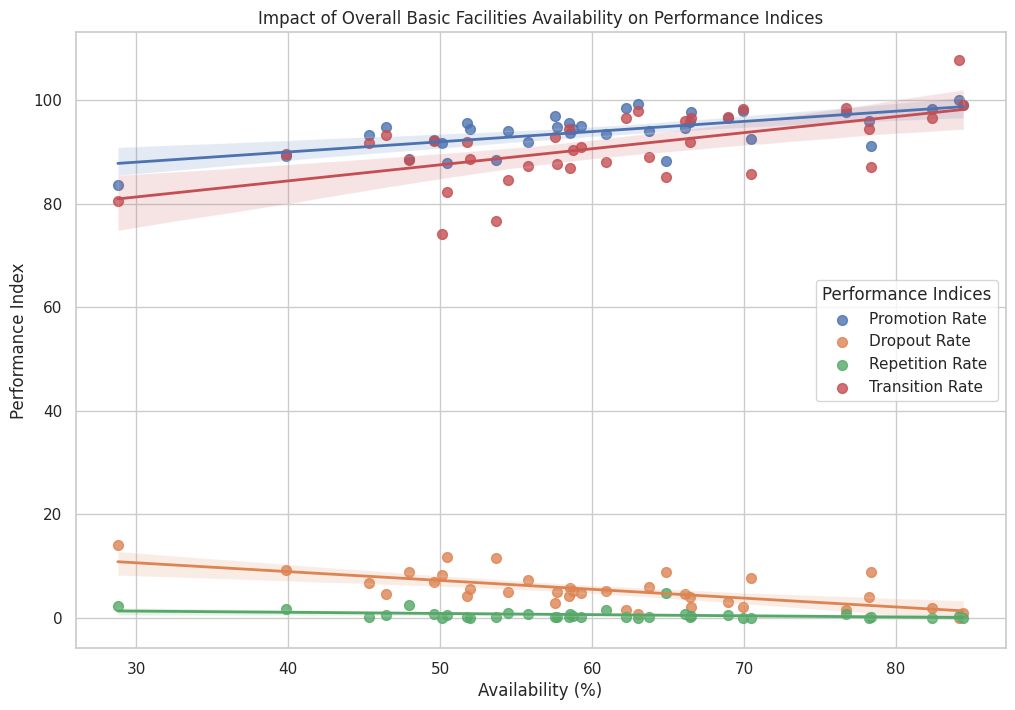

In [ ]:
#Scatter Plot with Regression Line: Impact of Basic Facilities Availability on Performance Indices
final_set['Mean Basic Facilities']=final_set[['Projector','Smart Class','Digital Library','Library','Playground',"Girls' Toilet","Boys' Toilet",'Electricity','Computers','Internet','Drinking Water','Hand wash']].mean(axis=1)
performance_indices=['Promotion Rate','Dropout Rate','Repetition Rate','Transition Rate']
plt.figure(figsize=(12, 8))
for index in performance_indices:
    sns.regplot(x='Mean Basic Facilities', y=index, data=final_set, label=index, scatter_kws={'s':50}, line_kws={'linewidth':2})
plt.title('Impact of Overall Basic Facilities Availability on Performance Indices')
plt.xlabel('Availability (%)')
plt.ylabel('Performance Index')
plt.legend(title='Performance Indices')
plt.show()


***Analytical Summary of Linear Trend Models***

**1. Dropout Rate**
* *Model Formula*: Dropout Rate = (Mean Basic Facilities + Intercept)
* *R-Squared*: 0.424
* *p-value*: < 0.0001 (significant)
* *Mean Basic Facilities*: -0.1705 (p < 0.0001)
* *Intercept*: 15.7729 (p < 0.0001)
* *Analysis*: The model explains 42.4% of the variance in dropout rates based on the availability of basic facilities. The negative coefficient for Mean Basic Facilities indicates that an increase in basic facilities is associated with a decrease in the dropout rate. This relationship is statistically significant, suggesting that improving basic facilities is likely to reduce dropout rates.

**2. Promotion Rate**
* *Model Formula*: Promotion Rate = (Mean Basic Facilities + Intercept)
* *R-Squared*: 0.438
* *p-value*: < 0.0001 (significant)
* *Mean Basic Facilities*: 0.1968 (p < 0.0001)
* *Intercept*: 82.0942 (p < 0.0001)
* *Analysis*: The model accounts for 43.8% of the variance in promotion rates based on basic facilities. The positive coefficient for Mean Basic Facilities suggests that more basic facilities are associated with higher promotion rates. This result is statistically significant, indicating a clear link between improved facilities and better promotion outcomes.

**3. Repetition Rate**
* *Model Formula*: Repetition Rate = (Mean Basic Facilities + Intercept)
* *R-Squared*: 0.0893
* *p-value*: 0.0812 (not significant)
* *Mean Basic Facilities*: -0.0227 (p = 0.0812)
* *Intercept*: 2.008 (p = 0.0149)
* *Analysis*: This model explains only 8.93% of the variance in repetition rates. The negative coefficient for Mean Basic Facilities suggests a potential decrease in repetition rates with increased facilities, but this relationship is not statistically significant at the 0.05 level. The impact of facilities on repetition rates may be less direct or influenced by other factors not captured in this model.

**4. Transition Rate**
* *Model Formula*: Transition Rate = (Mean Basic Facilities + Intercept)
* *R-Squared*: 0.345
* *p-value*: 0.0002 (significant)
* *Mean Basic Facilities*: 0.3090 (p = 0.0002)
* *Intercept*: 72.1433 (p < 0.0001)
* *Analysis*: The model explains 34.5% of the variance in transition rates. The positive coefficient for Mean Basic Facilities suggests that an increase in basic facilities is associated with higher transition rates. This result is statistically significant, indicating that improving facilities likely enhances the ability of students to transition smoothly between educational stages.

**Overall Insights:**
* *Significant Impact*: Basic facilities have a statistically significant impact on Dropout Rate, Transition Rate, and Promotion Rate. Improvements in basic facilities are generally associated with better educational outcomes in these areas.
* *Limited Impact*: The effect of basic facilities on Repetition Rate is not statistically significant, suggesting that other factors may play a more critical role in determining repetition rates.
* *R-Squared Values*: The models show moderate explanatory power for Dropout, Promotion, and Transition Rates, indicating that while basic facilities are important, they are part of a larger set of factors influencing educational performance.

**Recommendations:**
* *Focus on Facility Improvement*: Invest in upgrading basic facilities such as classrooms, libraries, and sanitation to potentially improve dropout and promotion rates.
* *Monitor and Evaluate*: Continuously monitor the impact of facility improvements and adjust strategies as needed to maximize educational outcomes.
* This summary provides a snapshot of how basic facilities correlate with educational performance metrics and highlights areas for potential focus and investment.

# Prediction Model
In our model, we are going to use the facilities with more direct impact on the educational outcomes for predicting the important or significant educational metrics. Lets choose the **Promotion Rate** and **Dropout Rate** as the important metrics to be predicted in our model.

## Split the Data frame into Features and Targets

In [ ]:
# FEATURES
data = final_set
features = data[['Projector', 'Smart Class', 'Digital Library','Library',
                 'Computers', 'Internet', 'Playground',
                 "Girls' Toilet", "Boys' Toilet",
                 'Electricity', 'Drinking Water',
                 'Hand wash']]

# TARGETS
promotion_rate = data['Promotion Rate']
dropout_rate = data['Dropout Rate']

## Train and test the data

In [ ]:
# Train and Test Data
X_train, X_test, y_train_prom, y_test_prom = train_test_split(features, promotion_rate, test_size=0.2, random_state=42)
_, _, y_train_drop, y_test_drop = train_test_split(features, dropout_rate, test_size=0.2, random_state=42)

## Selection of Appropriate Algorithm

Given that our project aims to predict promotion and dropout rates based on the availability percentage of different school facilities, the choice of algorithm should consider both the nature of the data and the problem. Since we are dealing with regression tasks, lets check the most suitable algorithms for our model, along with their characteristics:

In [ ]:
# Lets consider only Promotion Rate for model evaluation purpose
# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Regressor": SVR(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Elastic Net": ElasticNet()
}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train_prom)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test_prom, y_pred)
    mse = mean_squared_error(y_test_prom, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_prom, y_pred)

    print(f'{name} Evaluation:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}\n')


Linear Regression Evaluation:
MAE: 3.041158655730614
MSE: 11.264689889562717
RMSE: 3.3562910913034223
R2: 0.010657942475235105

Decision Tree Evaluation:
MAE: 3.5083333333333346
MSE: 19.16472222222221
RMSE: 4.377753102017313
R2: -0.6831768917839183

Support Vector Regressor Evaluation:
MAE: 2.6061766363732506
MSE: 10.464350697929119
RMSE: 3.2348648654818826
R2: 0.08094920040876619

Random Forest Evaluation:
MAE: 2.808583333333347
MSE: 10.454387611111224
RMSE: 3.233324544661613
R2: 0.08182422678839563

Gradient Boosting Evaluation:
MAE: 3.2223770402148357
MSE: 14.152748800734514
RMSE: 3.762013928833134
R2: -0.24299113028608832

K-Nearest Neighbors Evaluation:
MAE: 3.1700000000000053
MSE: 13.935377777777813
RMSE: 3.7330118909237098
R2: -0.22390012137180793

Elastic Net Evaluation:
MAE: 2.3882230409221066
MSE: 7.160106510550545
RMSE: 2.6758375344087213
R2: 0.37115050865199406



### Model Evaluation Analysis

Based on the model evaluation results, let's analyze and select the most appropriate model for predicting the promotion rate based on the given metrics.

**Metrics Overview:**
* MAE (Mean Absolute Error): Lower values indicate better performance.
* MSE (Mean Squared Error): Lower values indicate better performance.
* RMSE (Root Mean Squared Error): Lower values indicate better performance.
* R2 (R-squared): Values closer to 1 indicate better performance.

**Recommendation:**
* *Elastic Net:* This model shows the best overall performance with the lowest MAE, MSE, RMSE, and the highest R-squared value. It indicates the most accurate predictions and the best fit to the data.
* *Random Forest:* This model is great candidate, with competitive performance across all metrics. It handles non-linear relationships well and provides feature importance.

## Elastic Net Model and Evaluation

In [ ]:
# Train Elastic Net Model for Promotion Rate
elastic_net_prom = ElasticNet(random_state=42)
elastic_net_prom.fit(X_train, y_train_prom)

# Predictions
y_pred_prom = elastic_net_prom.predict(X_test)

# Evaluation for Promotion Rate
mae_prom = mean_absolute_error(y_test_prom, y_pred_prom)
mse_prom = mean_squared_error(y_test_prom, y_pred_prom)
rmse_prom = np.sqrt(mse_prom)
r2_prom = r2_score(y_test_prom, y_pred_prom)

print("Elastic Net Promotion Rate Evaluation:")
print(f"MAE: {mae_prom}")
print(f"MSE: {mse_prom}")
print(f"RMSE: {rmse_prom}")
print(f"R2: {r2_prom}")

# Train Elastic Net Model for Dropout Rate
elastic_net_drop = ElasticNet(random_state=42)
elastic_net_drop.fit(X_train, y_train_drop)

# Predictions
y_pred_drop = elastic_net_drop.predict(X_test)

# Evaluation for Dropout Rate
mae_drop = mean_absolute_error(y_test_drop, y_pred_drop)
mse_drop = mean_squared_error(y_test_drop, y_pred_drop)
rmse_drop = np.sqrt(mse_drop)
r2_drop = r2_score(y_test_drop, y_pred_drop)

print("\nElastic Net Dropout Rate Evaluation:")
print(f"MAE: {mae_drop}")
print(f"MSE: {mse_drop}")
print(f"RMSE: {rmse_drop}")
print(f"R2: {r2_drop}")

Elastic Net Promotion Rate Evaluation:
MAE: 2.3882230409221066
MSE: 7.160106510550545
RMSE: 2.6758375344087213
R2: 0.37115050865199406

Elastic Net Dropout Rate Evaluation:
MAE: 2.5653386557510585
MSE: 9.118046802105978
RMSE: 3.019610372565636
R2: -0.31864584031440724


### Visual Analysis of Elastic Net Model

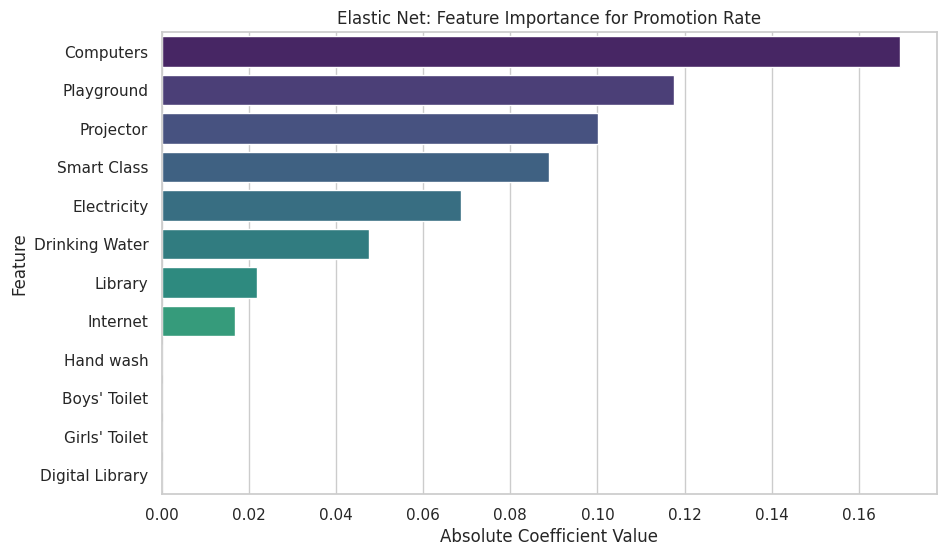

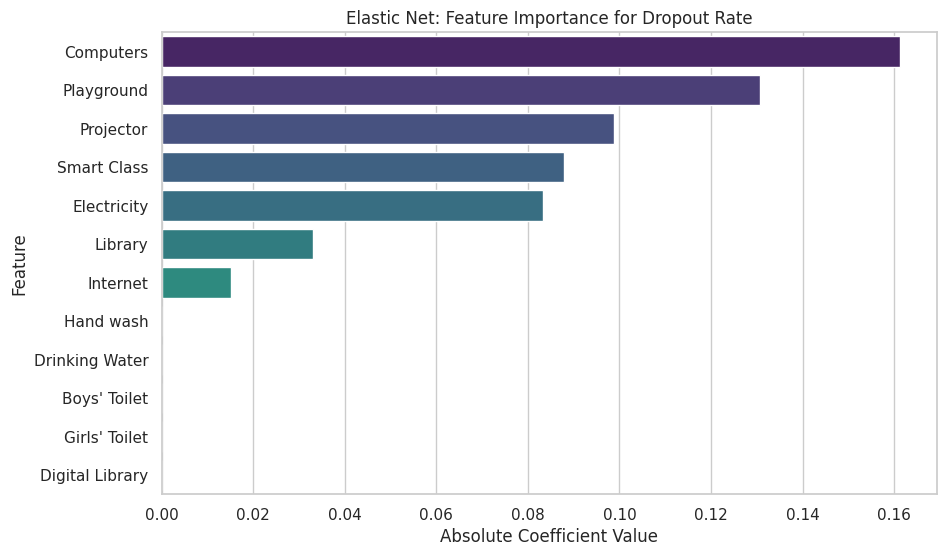

In [ ]:
# Feature Importance for Promotion Rate
plt.figure(figsize=(10, 6))
importance_prom = np.abs(elastic_net_prom.coef_)  # Absolute value of coefficients
indices_prom = np.argsort(importance_prom)[::-1]
sns.barplot(x=importance_prom[indices_prom], y=features.columns[indices_prom], palette='viridis')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Elastic Net: Feature Importance for Promotion Rate')
plt.show()

# Feature Importance for Dropout Rate
plt.figure(figsize=(10, 6))
importance_drop = np.abs(elastic_net_drop.coef_)  # Absolute value of coefficients
indices_drop = np.argsort(importance_drop)[::-1]
sns.barplot(x=importance_drop[indices_drop], y=features.columns[indices_drop], palette='viridis')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Elastic Net: Feature Importance for Dropout Rate')
plt.show()

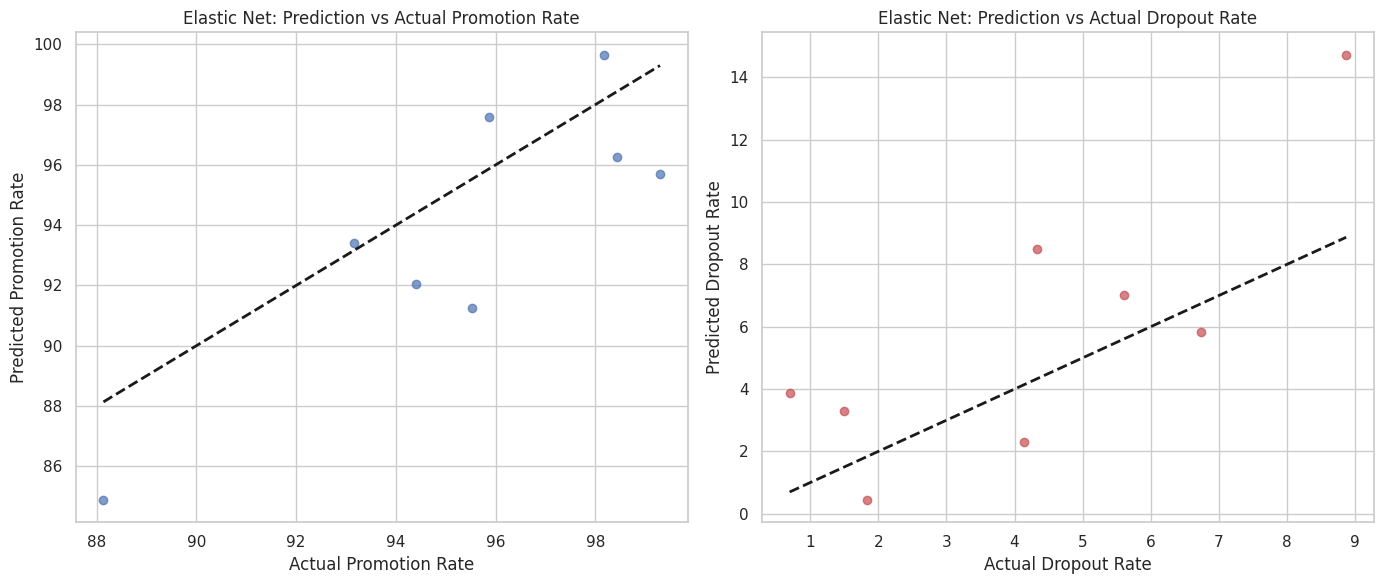

In [ ]:
# Prediction vs Actual for Promotion Rate
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_prom, y_pred_prom, alpha=0.7, color='b')
plt.plot([y_test_prom.min(), y_test_prom.max()], [y_test_prom.min(), y_test_prom.max()], 'k--', lw=2)
plt.xlabel('Actual Promotion Rate')
plt.ylabel('Predicted Promotion Rate')
plt.title('Elastic Net: Prediction vs Actual Promotion Rate')

# Prediction vs Actual for Dropout Rate
y_pred_drop = elastic_net_drop.predict(X_test)

plt.subplot(1, 2, 2)
plt.scatter(y_test_drop, y_pred_drop, alpha=0.7, color='r')
plt.plot([y_test_drop.min(), y_test_drop.max()], [y_test_drop.min(), y_test_drop.max()], 'k--', lw=2)
plt.xlabel('Actual Dropout Rate')
plt.ylabel('Predicted Dropout Rate')
plt.title('Elastic Net: Prediction vs Actual Dropout Rate')

plt.tight_layout()
plt.show()

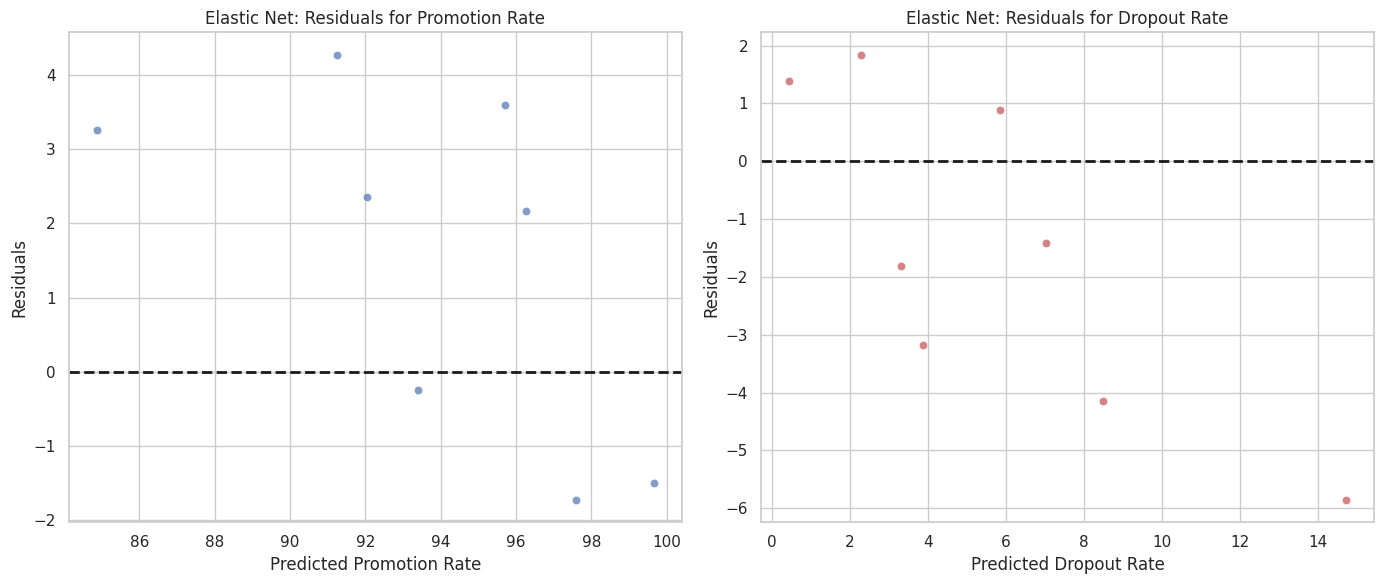

In [ ]:
# Residuals for Promotion Rate
residuals_prom = y_test_prom - y_pred_prom

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_prom, y=residuals_prom, color='b', alpha=0.7)
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Promotion Rate')
plt.ylabel('Residuals')
plt.title('Elastic Net: Residuals for Promotion Rate')

# Residuals for Dropout Rate
residuals_drop = y_test_drop - y_pred_drop

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_drop, y=residuals_drop, color='r', alpha=0.7)
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Dropout Rate')
plt.ylabel('Residuals')
plt.title('Elastic Net: Residuals for Dropout Rate')

plt.tight_layout()
plt.show()

## Random Forest Model and Evaluation

In [ ]:
# Train the models
prom_model = RandomForestRegressor()
drop_model = RandomForestRegressor()

prom_model.fit(X_train, y_train_prom)
drop_model.fit(X_train, y_train_drop)

# Predictions
y_pred_prom = prom_model.predict(X_test)
y_pred_drop = drop_model.predict(X_test)

# Evaluation metrics for promotion rate model
mae_prom = mean_absolute_error(y_test_prom, y_pred_prom)
mse_prom = mean_squared_error(y_test_prom, y_pred_prom)
rmse_prom = np.sqrt(mse_prom)
r2_prom = r2_score(y_test_prom, y_pred_prom)

print(f'Promotion Rate Model Evaluation:')
print(f'MAE: {mae_prom}')
print(f'MSE: {mse_prom}')
print(f'RMSE: {rmse_prom}')
print(f'R2: {r2_prom}')

# Evaluation metrics for dropout rate model
mae_drop = mean_absolute_error(y_test_drop, y_pred_drop)
mse_drop = mean_squared_error(y_test_drop, y_pred_drop)
rmse_drop = np.sqrt(mse_drop)
r2_drop = r2_score(y_test_drop, y_pred_drop)

print(f'\nDropout Rate Model Evaluation:')
print(f'MAE: {mae_drop}')
print(f'MSE: {mse_drop}')
print(f'RMSE: {rmse_drop}')
print(f'R2: {r2_drop}')

Promotion Rate Model Evaluation:
MAE: 2.9502083333333466
MSE: 11.004039152777844
RMSE: 3.3172336596594825
R2: 0.033550071664252945

Dropout Rate Model Evaluation:
MAE: 1.976750000000001
MSE: 6.206771722222224
RMSE: 2.491339343048679
R2: 0.1023808178524529


### Visual Analysis of Random Forest Regressor Model

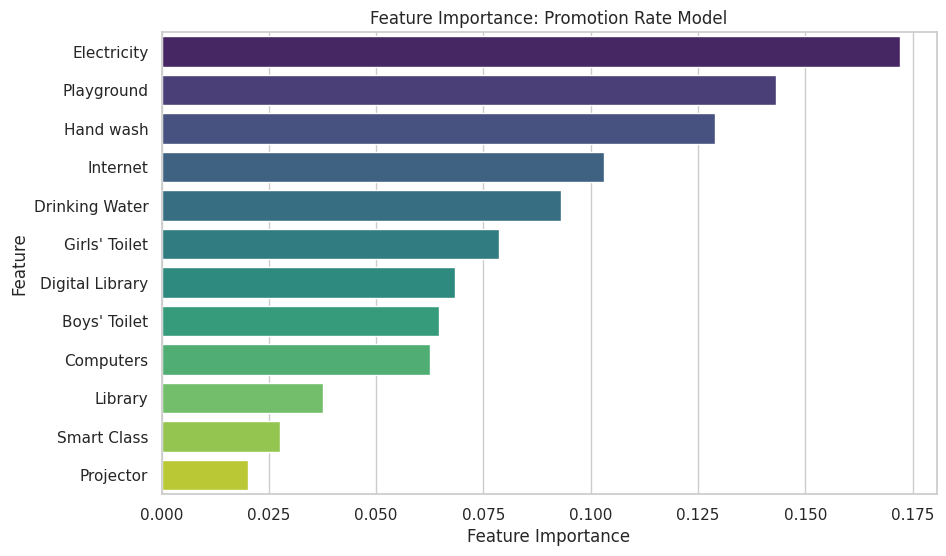

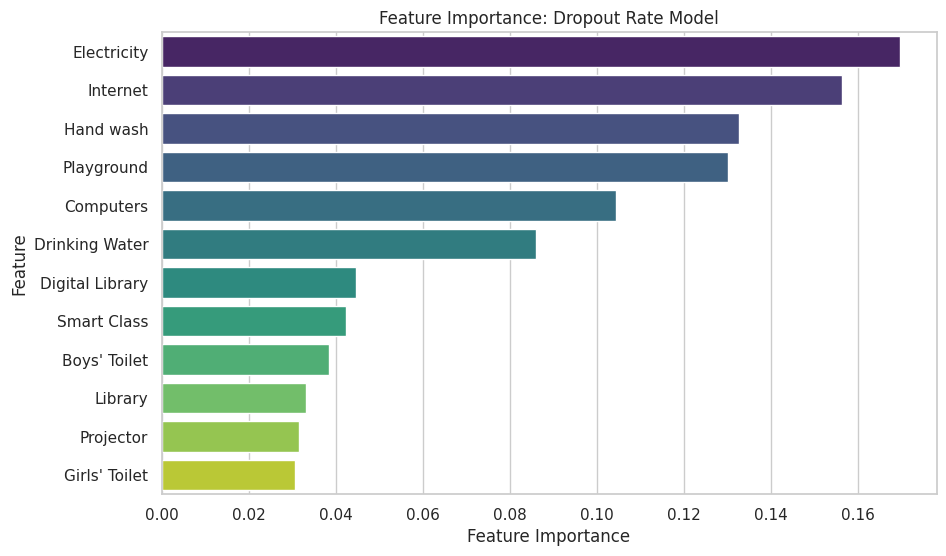

In [ ]:
# Feature Importance for Promotion Rate Model
importances_prom = prom_model.feature_importances_
indices_prom = np.argsort(importances_prom)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_prom[indices_prom], y=features.columns[indices_prom], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance: Promotion Rate Model')
plt.show()

# Feature Importance for Dropout Rate Model
importances_drop = drop_model.feature_importances_
indices_drop = np.argsort(importances_drop)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_drop[indices_drop], y=features.columns[indices_drop], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance: Dropout Rate Model')
plt.show()

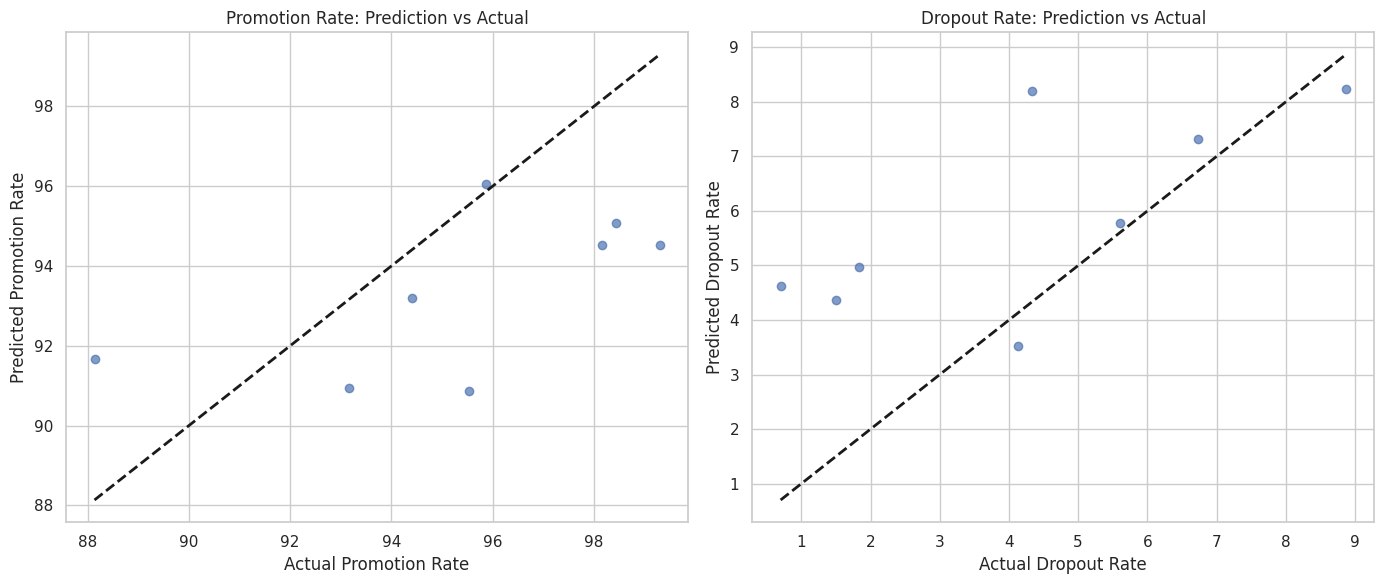

In [ ]:
# Prediction vs Actual for Promotion Rate Model
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_prom, y_pred_prom, alpha=0.7)
plt.plot([y_test_prom.min(), y_test_prom.max()], [y_test_prom.min(), y_test_prom.max()], 'k--', lw=2)
plt.xlabel('Actual Promotion Rate')
plt.ylabel('Predicted Promotion Rate')
plt.title('Promotion Rate: Prediction vs Actual')

# Prediction vs Actual for Dropout Rate Model
plt.subplot(1, 2, 2)
plt.scatter(y_test_drop, y_pred_drop, alpha=0.7)
plt.plot([y_test_drop.min(), y_test_drop.max()], [y_test_drop.min(), y_test_drop.max()], 'k--', lw=2)
plt.xlabel('Actual Dropout Rate')
plt.ylabel('Predicted Dropout Rate')
plt.title('Dropout Rate: Prediction vs Actual')

plt.tight_layout()
plt.show()

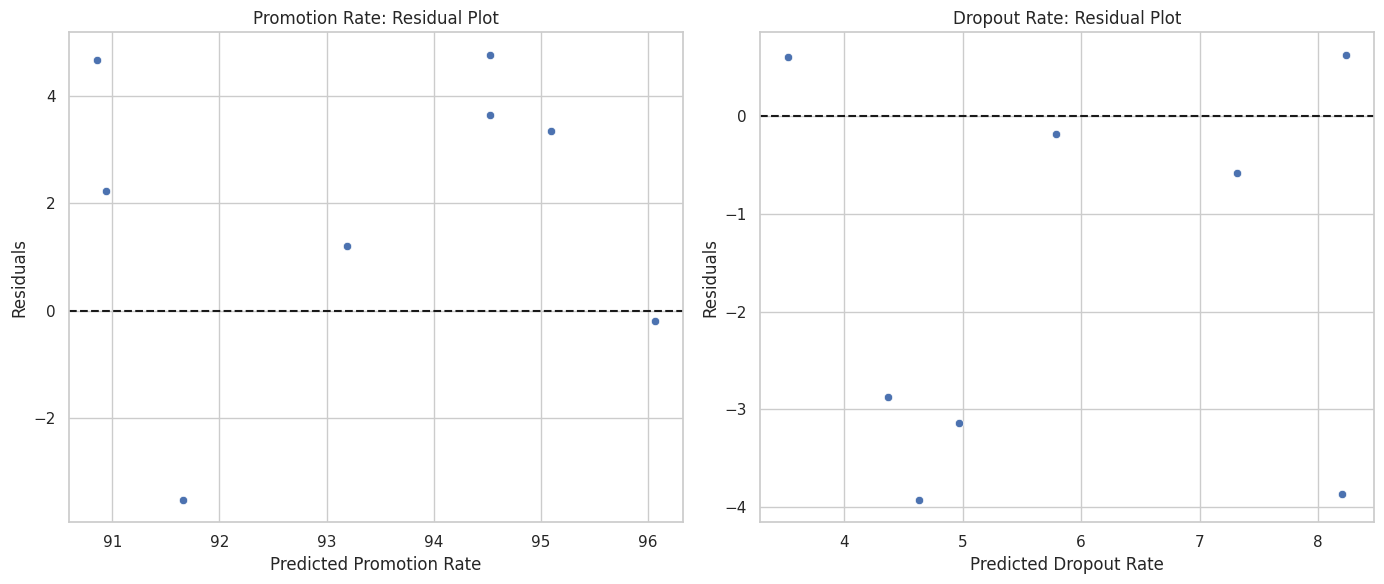

In [ ]:
# Residuals for Promotion Rate Model
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
residuals_prom = y_test_prom - y_pred_prom
sns.scatterplot(x=y_pred_prom, y=residuals_prom)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted Promotion Rate')
plt.ylabel('Residuals')
plt.title('Promotion Rate: Residual Plot')

# Residuals for Dropout Rate Model
plt.subplot(1, 2, 2)
residuals_drop = y_test_drop - y_pred_drop
sns.scatterplot(x=y_pred_drop, y=residuals_drop)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted Dropout Rate')
plt.ylabel('Residuals')
plt.title('Dropout Rate: Residual Plot')

plt.tight_layout()
plt.show()

## Explanation for Visual Analysis of Model Characteristics:

* *Prediction vs. Actual Plot:* Scatter plots compare the actual values with the predicted values. The closer the points are to the diagonal line, the better the model's performance.
* *Residual Plot:* Scatter plots of the residuals (errors) vs. the predicted values help to check if there are any patterns in the errors. Ideally, the points should be randomly scattered around the horizontal line (residual = 0).
* *Feature Importance Plot:* Bar plots of the feature coefficients indicate the importance of each feature. Features with larger absolute coefficient values are considered more important.

**Both the models align with the desired characteristics.**

## Significance of the Prediction Model for the Project

In the context of our project aimed at improving educational infrastructure and technology to enhance student performance and align with Sustainable Development Goal 4 (SDG 4), the predictive models we've developed play a crucial role. Here’s how they contribute to your project's objectives:

**1. Understanding the Impact of Infrastructure on Student Performance**

*Objective*: To develop predictive models for student performance based on infrastructure quality.

*Utility:*
* Quantifying Relationships: The prediction models (Random Forest and Elastic Net) analyze how various elements of school infrastructure and digital initiatives influence key outcomes like promotion rates and dropout rates.
* Identifying Key Factors: By understanding which infrastructure elements (e.g., availability of smart classrooms, digital libraries, sanitation facilities) most significantly impact student outcomes, the models help in identifying critical areas for intervention.

**2. Targeted Interventions for Improvement**

*Objective*: To propose actionable solutions and policy recommendations to improve educational facilities.

*Utility:*
* Data-Driven Recommendations: The insights from these models provide a data-driven basis for recommending specific improvements. For instance, if the models reveal that the lack of a digital library is strongly associated with lower promotion rates, targeted investments in digital libraries can be prioritized.
* Resource Allocation: The models can guide how to allocate resources more effectively by highlighting which infrastructure improvements will yield the greatest benefit for student performance.

**3. Assessing Regional Disparities**

*Objective*: To understand regional disparities in educational infrastructure and technology.

*Utility:*
* Regional Analysis: By applying the models to different regions, we can assess how regional variations in infrastructure affect student outcomes. This can reveal disparities and highlight regions that need urgent attention.
* Customized Solutions: Insights from regional analyses allow for the development of customized solutions tailored to the specific needs and challenges of each region.

**4. Evaluating the Effectiveness of Proposed Solutions**

*Objective*: To assess the potential impact of these solutions on achieving SDG 4.

*Utility:*
* Impact Assessment: The predictive models can simulate the potential impact of proposed infrastructure improvements on student outcomes. This helps in evaluating whether the solutions will likely contribute to the achievement of SDG 4 by improving educational quality.
* Scenario Analysis: By running different scenarios (e.g., what if we increase digital library availability by 20%?), you can forecast the possible effects of various interventions and prioritize actions based on projected outcomes.

**Summary**

The prediction model is a key tool in our project’s strategy to enhance educational infrastructure and align with SDG 4. They offer valuable insights into the relationship between infrastructure quality and student performance, guide targeted interventions, assess regional disparities, and evaluate the potential impact of proposed improvements. By leveraging these models, our project can ensure that investments in educational facilities are both effective and aligned with the goal of providing inclusive and equitable quality education.

## Conclusion

The predictive models offer significant value by highlighting the relative impact of educational infrastructure on student performance. They help identify key areas for improvement, guide targeted interventions, and address regional disparities. However, these models are just one piece of the puzzle. A comprehensive approach to enhancing education must also consider other critical factors that influence student outcomes. By integrating these insights into a broader strategy, we can better support the goal of providing inclusive and equitable quality education as outlined in SDG 4.